In [164]:
import numpy as np
import Bio
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import matplotlib.pyplot as plt
import pandas as pd
#import biolib
import re
import os
import requests as r

from io import StringIO
from Bio import SeqIO

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_regression
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

import math
import xgboost as xgb

import seaborn as sns
import shap

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from scipy import stats

import imblearn
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import RocCurveDisplay, auc

import upsetplot
from upsetplot import plot

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

import quantiprot
from quantiprot.utils.io import load_fasta_file
from quantiprot.utils.feature import Feature, FeatureSet
from quantiprot.metrics.aaindex import get_aaindex_file
from quantiprot.metrics.basic import average
from quantiprot.metrics.aaindex import get_aa2charge, get_aa2hydropathy
from quantiprot.metrics.basic import average, average_absolute

In [597]:
sns.set_style('white')
sns.set_context("paper", font_scale = 2)

# Preprocessing

# Getting Proteins and LCMS Data

In [50]:
df = pd.read_excel('C:\\Users\\jared\\Downloads\\07181001_MBsubtractedcorrectly_listofproteinsforML_2.xlsx', None)

In [617]:
df1 = pd.read_excel('C:\\Users\\jared\\Downloads\\07181001_MBsubtractedcorrectly_listofproteinsforML_2.xlsx',sheet_name = list(df.keys())[0])
df1.columns = df1.iloc[0,:]
df1.drop([0],axis = 0, inplace = True)
df1.index = df1['Protein']
df1.drop(['Protein'], axis = 1, inplace = True)

samples = list()
allPres = list()
for z in df1.columns:
    proteinPres = list()
    for x in df1[z]:
        if(math.isnan(x)):
            proteinPres.append(0)
        else:
            proteinPres.append(1)
    samples.append(z)
    allPres.append(proteinPres)
    
allPresdf=pd.DataFrame(allPres).transpose()
allPresdf.columns = samples
allPresdf.index = df1.index #Any amount of protein in the corona

df1 = pd.read_excel('C:\\Users\\jared\\Downloads\\07181001_MBsubtractedcorrectly_listofproteinsforML_2.xlsx',sheet_name = list(df.keys())[0])
df1.columns = df1.iloc[0,:]
df1.drop([0],axis = 0, inplace = True)
df1.index = df1['Protein']
df1.drop(['Protein'], axis = 1, inplace = True)

samples = list()
allPres = list()
for z in df1.columns:
    proteinPres = list()
    for x in df1[z]:
        if(math.isnan(x)):
            proteinPres.append(0)
        else:
            if(x > 0):
                proteinPres.append(1)
            else:
                proteinPres.append(0)
    samples.append(z)
    allPres.append(proteinPres)
    
allPresdfEnrich=pd.DataFrame(allPres).transpose()
allPresdfEnrich.columns = samples
allPresdfEnrich.index = df1.index #Only more in the corona than in serum

df2 = pd.read_excel('C:\\Users\\jared\\Downloads\\07181001_MBsubtractedcorrectly_listofproteinsforML_2.xlsx',sheet_name = list(df.keys())[1])
samples = list()
allPros=pd.DataFrame({'Protein':allPresdf.index})
for z in df2.columns:
    allPros[z] = 0
    listPros=df2[z].dropna()
    print(set(listPros).difference(set(allPresdf.index)))
    allPros.loc[allPros['Protein'].isin(listPros),z] = 1
    samples.append(z)
allPros.index  = allPros['Protein']
allPros.drop(['Protein'], axis = 1, inplace = True) #Not found in serum, only on MB and in NPs

df3 = pd.read_excel('C:\\Users\\jared\\Downloads\\07181001_MBsubtractedcorrectly_listofproteinsforML_2.xlsx',sheet_name = list(df.keys())[2])
samples = list()
allProsCorona=pd.DataFrame({'Protein':allPresdf.index})
for z in df3.columns:
    allProsCorona[z] = 0
    listPros=df3[z].dropna()
    print(set(listPros).difference(set(allPresdf.index)))
    allProsCorona.loc[allProsCorona['Protein'].isin(listPros),z] = 1
    samples.append(z)
allProsCorona.index  =allProsCorona[ 'Protein']
allProsCorona.drop(['Protein'], axis = 1, inplace = True) #Not on MB or in serum, only nanostructure corona

mbandCorona=allProsCorona + allPros #Only found in nanostructures (no MB or serum) and not found in serum (just MB and NPs)
allPresdf.columns=allProsCorona.columns 
coronaandfc= allPresdf + allProsCorona #Only found in nanostructure (not MB or serum), and any amount of protein in corona (enriched or depleted)

coronaPresent = allPros + allPresdf + allProsCorona
coronaPresent.index = allPresdf.index
coronaPresent=coronaPresent.replace(2,1)
coronaPresent=coronaPresent.replace(3,1)

samples = list()
proteins = list()
abundanceVals = list()
for z in coronaPresent.columns:
    for x in range(len(coronaPresent[z])):
        proteins.append(coronaPresent.index[x])
        samples.append(z)
        abundanceVals.append(coronaPresent.loc[coronaPresent.index[x],z])
allPresent = pd.DataFrame({'Protein':proteins, 'Abundance':abundanceVals, 'Sample':samples})
allPresent.to_csv('PresentProteins8_4.csv')

allPresdfEnrich.columns=allProsCorona.columns
coronaEnrich = allPresdfEnrich+allProsCorona+allPros
coronaEnrich.index = allPresdfEnrich.index
coronaEnrich=coronaEnrich.replace(2,1)
coronaEnrich=coronaEnrich.replace(3,1)
samples = list()
proteins = list()
abundanceVals = list()
for z in coronaEnrich.columns:
    for x in range(len(coronaEnrich[z])):
        proteins.append(coronaEnrich.index[x])
        samples.append(z)
        abundanceVals.append(coronaEnrich.loc[coronaEnrich.index[x],z])
allEnrich = pd.DataFrame({'Protein':proteins, 'Abundance':abundanceVals, 'Sample':samples})
allEnrich.to_csv('EnrichedProteins8_4.csv')

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


# Getting Protein Data

## NetSurf Data Loading

In [407]:
netSurf1=pd.read_csv('C:\\Users\\jared\\Downloads\\netSurf\\10thNetSurf59.csv')
for fil in os.listdir('C:\\Users\\jared\\Downloads\\netSurf'):
    if(fil != '10thNetSurf59.csv'):
        netSurf2=pd.read_csv('C:\\Users\\jared\\Downloads\\netSurf\\' + fil)
        netSurf1 = netSurf1.append(netSurf2)
netSurf2=pd.read_csv('C:\\Users\\jared\\Downloads\\netSurf\\11thNetSurf.csv')
netSurf1 = netSurf1.append(netSurf2)
netSurf1.reset_index(inplace=True, drop = True)
netSurf1.to_csv('AllNetSurf.csv')

netSurf = netSurf1

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

In [456]:
netSurf=netSurf.drop_duplicates(subset=['id', 'n'])

id seq    n       rsa         asa q3   p[q3_H]   p[q3_E]  \
0       Q9UL12   M    1  0.789542  157.987430  C  0.000087  0.000005   
1       Q9UL12   A    2  0.774804   85.383374  C  0.000744  0.000072   
2       Q9UL12   S    3  0.703493   82.449393  C  0.001747  0.000398   
3       Q9UL12   L    4  0.528584   96.783764  C  0.011470  0.000845   
4       Q9UL12   S    5  0.539390   63.216476  C  0.014817  0.000728   
...        ...  ..  ...       ...         ... ..       ...       ...   
282999  Q562R1   H  372  0.468849   85.283645  H  0.881783  0.010275   
283000  Q562R1   R  373  0.536125  122.772612  H  0.744162  0.018186   
283001  Q562R1   K  374  0.312246   64.228915  H  0.658580  0.027962   
283002  Q562R1   C  375  0.131619   18.479304  C  0.238356  0.064927   
283003  Q562R1   F  376  0.468638   94.055569  C  0.001807  0.000581   

         p[q3_C] q8  ...   p[q8_H]       p[q8_I]   p[q8_B]   p[q8_E]  \
0       0.999908  C  ...  0.000029  2.919334e-09  0.000005  0.000001   
1       0.999184  C  ...  0.000316  1.273643e-07  0.000015  0.000030   
2       0.997855  C  ...  0.000836  1.033893e-06  0.000097  0.000179   
3       0.987684  C  ...  0.006018  1.201380e-05  0.000260  0.000482   
4       0.984456  C  ...  0.007161  1.343145e-05  0.000239  0.000393   
...          ... ..  ...       ...           ...       ...       ...   
282999  0.107942  H  ...  0.675293  4.481022e-02  0.001900  0.009841   
283000  0.237652  H  ...  0.555085  6.067727e-02  0.003888  0.014620   
283001  0.313457  H  ...  0.420371  6.875839e-02  0.007230  0.020999   
283002  0.696716  C  ...  0.140845  2.909060e-02  0.043682  0.037716   
283003  0.997612  C  ...  0.000683  1.627198e-05  0.000645  0.000401   

         p[q8_S]   p[q8_T]   p[q8_C]         phi         psi  disorder  
0       0.000021  0.000046  0.999894  -82.074158  154.007019  0.994608  
1       0.000157  0.000217  0.999223  -83.931923  152.052795  0.984141  
2       0.000699  0.000520  0.997495  -88.004150  145.202301  0.983311  
3       0.002675  0.003688  0.985246  -77.955765  -23.619761  0.976514  
4       0.002147  0.003590  0.984902  -76.756653  -27.122856  0.967184  
...          ...       ...       ...         ...         ...       ...  
282999  0.015500  0.071311  0.050737  -69.707924  -31.443937  0.018392  
283000  0.036645  0.119509  0.102341  -78.655724  -24.078358  0.032735  
283001  0.055368  0.163405  0.134442  -90.805023   -9.021697  0.033557  
283002  0.114847  0.167854  0.403967  -99.418571   27.209232  0.041466  
283003  0.004864  0.008474  0.984236 -101.525040   97.216873  0.079003  

[273955 rows x 21 columns]

In [424]:
duplicatedNetSurf=list()
for x in range(len(np.unique(netSurf['id']))):
    protein1=np.unique(netSurf['id'])[x]
    lenAA = max(netSurf.loc[netSurf['id'] == protein1]['n'])
    lenNetSurf = len(netSurf.loc[netSurf['id'] == protein1])
    if(lenNetSurf > lenAA ):
        duplicatedNetSurf.append(protein1)
    if(lenAA > lenNetSurf):
        print('wierd'+protein1)

In [452]:
set(proteinIDs).difference(set(np.unique(netSurf['id'])))

{'F6WE04',
 'H0Y8K0',
 'P20929',
 'P35268',
 'P62979',
 'P62987',
 'Q03001',
 'Q5TEH5',
 'Q7Z5P9',
 'Q8NDA2',
 'Q8WXH0',
 'Q9NU22',
 'Q9Y6R7'}

In [455]:
ofile = open("netSurfProteins8_5.txt", "w")

for i in range(len(proteinSeqs)):
    if(proteinIDs[i] in list(set(proteinIDs).difference(set(np.unique(netSurf['id']))))):
        ofile.write(">" + proteinIDs[i] + "\n" +str(ProteinAnalysis(proteinSeqs[i]).sequence)+ "\n")
ofile.close()

In [440]:
sub.duplicated(subset=['seq','n']).value_counts()

False    446
True     446
dtype: int64

In [434]:
netSurf.loc[netSurf['id'] == 'P01860'].duplicated().value_counts()

False    892
dtype: int64

In [444]:
sub=netSurf.loc[netSurf['id'] == 'Q4VXU2']

In [450]:
sub.duplicated(subset=['seq','n']).value_counts()

True     1228
False     614
dtype: int64

In [445]:
sub[sub['n'] == 1]

id seq  n       rsa         asa q3   p[q3_H]   p[q3_E]   p[q3_C]  \
215686  Q4VXU2   M  1  0.863536  172.793589  C  0.000015  0.000008  0.999977   
216300  Q4VXU2   M  1  0.865187  173.123905  C  0.000015  0.000007  0.999979   
216914  Q4VXU2   M  1  0.866308  173.348321  C  0.000014  0.000006  0.999980   

       q8  ...   p[q8_H]       p[q8_I]   p[q8_B]   p[q8_E]   p[q8_S]  \
215686  C  ...  0.000003  7.985692e-10  0.000006  0.000002  0.000016   
216300  C  ...  0.000003  7.500367e-10  0.000005  0.000002  0.000016   
216914  C  ...  0.000003  6.600653e-10  0.000005  0.000002  0.000015   

         p[q8_T]   p[q8_C]        phi         psi  disorder  
215686  0.000034  0.999938 -88.505760  145.245483  0.995216  
216300  0.000034  0.999939 -88.070015  144.623764  0.995286  
216914  0.000031  0.999944 -87.898399  144.788712  0.995520  

[3 rows x 21 columns]

In [438]:
sub['n']

166014      1
166015      2
166016      3
166017      4
166018      5
         ... 
166901    442
166902    443
166903    444
166904    445
166905    446
Name: n, Length: 892, dtype: int64

In [443]:
for pro in duplicatedNetSurf:
    #if(len(netSurf.loc[netSurf['id'] == pro].duplicated().value_counts())==1):
    #    print(pro)
    #elif(netSurf.loc[netSurf['id'] == pro].duplicated().value_counts()[0]==netSurf.loc[netSurf['id'] == pro].duplicated().value_counts()[1]):
    #    print('good')
    #else:
    #    print(pro)
    if(netSurf.loc[netSurf['id'] == pro].duplicated(subset=['seq','n']).value_counts()[0] == netSurf.loc[netSurf['id'] == pro].duplicated(subset=['seq','n']).value_counts()[1]):
        print('Good')
    else:
        print(pro)

Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Q4VXU2
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good
Good


In [423]:
netSurf.loc[netSurf['id'] == 'A0A075B6H7'].duplicated().value_counts()[0]==netSurf.loc[netSurf['id'] == 'A0A075B6H7'].duplicated().value_counts()[1]

True

In [416]:
max(netSurf.loc[netSurf['id'] == 'Q9UL12']['n'])

918

In [417]:
len(netSurf.loc[netSurf['id'] == 'Q9UL12'])

918

In [415]:
netSurf.loc[netSurf['id'] == 'Q9UL12']

id seq    n       rsa         asa q3   p[q3_H]   p[q3_E]   p[q3_C]  \
0    Q9UL12   M    1  0.789542  157.987430  C  0.000087  0.000005  0.999908   
1    Q9UL12   A    2  0.774804   85.383374  C  0.000744  0.000072  0.999184   
2    Q9UL12   S    3  0.703493   82.449393  C  0.001747  0.000398  0.997855   
3    Q9UL12   L    4  0.528584   96.783764  C  0.011470  0.000845  0.987684   
4    Q9UL12   S    5  0.539390   63.216476  C  0.014817  0.000728  0.984456   
..      ...  ..  ...       ...         ... ..       ...       ...       ...   
913  Q9UL12   V  914  0.263751   40.538533  C  0.066480  0.153482  0.780038   
914  Q9UL12   K  915  0.493100  101.430667  C  0.103359  0.173084  0.723558   
915  Q9UL12   G  916  0.336277   26.464991  C  0.076637  0.219380  0.703984   
916  Q9UL12   I  917  0.390538   72.249570  C  0.035676  0.232950  0.731373   
917  Q9UL12   Y  918  0.524503  112.086213  C  0.001312  0.002286  0.996402   

    q8  ...   p[q8_H]       p[q8_I]   p[q8_B]   p[q8_E]   p[q8_S]   p[q8_T]  \
0    C  ...  0.000029  2.919334e-09  0.000005  0.000001  0.000021  0.000046   
1    C  ...  0.000316  1.273643e-07  0.000015  0.000030  0.000157  0.000217   
2    C  ...  0.000836  1.033893e-06  0.000097  0.000179  0.000699  0.000520   
3    C  ...  0.006018  1.201380e-05  0.000260  0.000482  0.002675  0.003688   
4    C  ...  0.007161  1.343145e-05  0.000239  0.000393  0.002147  0.003590   
..  ..  ...       ...           ...       ...       ...       ...       ...   
913  C  ...  0.024377  2.605759e-04  0.050091  0.110756  0.084023  0.073142   
914  C  ...  0.039515  8.237276e-04  0.044273  0.121330  0.086596  0.127782   
915  C  ...  0.027942  6.308221e-04  0.022560  0.190280  0.106173  0.123292   
916  C  ...  0.010752  2.617403e-04  0.041253  0.190227  0.075418  0.061891   
917  C  ...  0.000287  1.166941e-06  0.000465  0.001647  0.002231  0.002951   

      p[q8_C]         phi         psi  disorder  
0    0.999894  -82.074158  154.007019  0.994608  
1    0.999223  -83.931923  152.052795  0.984141  
2    0.997495  -88.004150  145.202301  0.983311  
3    0.985246  -77.955765  -23.619761  0.976514  
4    0.984902  -76.756653  -27.122856  0.967184  
..        ...         ...         ...       ...  
913  0.611767  -87.994324  113.212219  0.123025  
914  0.515934  -95.956017  111.402443  0.114918  
915  0.469048 -120.801651  136.193329  0.075570  
916  0.591399 -100.324516  101.884583  0.112884  
917  0.991725 -115.843414  134.153625  0.182142  

[918 rows x 21 columns]

In [457]:
netSurf1=pd.read_csv('C:\\Users\\jared\\Downloads\\netSurf\\10thNetSurf59.csv')
for fil in os.listdir('C:\\Users\\jared\\Downloads\\netSurf'):
    if(fil != '10thNetSurf59.csv'):
        netSurf2=pd.read_csv('C:\\Users\\jared\\Downloads\\netSurf\\' + fil)
        netSurf1 = netSurf1.append(netSurf2)
netSurf2=pd.read_csv('C:\\Users\\jared\\Downloads\\netSurf\\11thNetSurf.csv')
netSurf1 = netSurf1.append(netSurf2)
netSurf1.reset_index(inplace=True, drop = True)
netSurf1=netSurf1.drop_duplicates(subset=['id', 'n'])
netSurf1.to_csv('AllNetSurf.csv')
netSurf = netSurf1
        
disMean = list()
psiMean = list()
phiMean = list()
totList = list()
totListaa = list()
pros = list()
for x in range(len(np.unique(netSurf['id']))):
    protein1=np.unique(netSurf['id'])[x]
    pros.append(protein1)
    subSurf =netSurf[netSurf['id'] == protein1]
    disMean.append(np.mean(subSurf['disorder']))
    psiMean.append(np.mean(subSurf['psi']))
    phiMean.append(np.mean(subSurf['phi']))
    perProteinList = list()
    for y in np.unique(netSurf['q8']):
        if(y in subSurf['q8'].value_counts()):
            perProteinList.append(subSurf['q8'].value_counts()[y]/sum(subSurf['q8'].value_counts()))
        else:
            perProteinList.append(0)
    totList.append(perProteinList)

    perProteinListaa = list()
    for y in np.unique(netSurf['seq']):
        if(y in subSurf['seq'].value_counts()):
            perProteinListaa.append(subSurf['seq'].value_counts()[y]/sum(subSurf['seq'].value_counts()))
        else:
            perProteinListaa.append(0)
    totListaa.append(perProteinListaa)
    
totListaaExpo = list()
for x in range(len(np.unique(netSurf['id']))):
    protein1=np.unique(netSurf['id'])[x]
    subSurf =netSurf[netSurf['id'] == protein1]
    perProteinListaaExpo = list()
    for y in np.unique(netSurf['seq']):
        if(y in subSurf['seq'].value_counts()):
            perProteinListaaExpo.append(sum(subSurf[subSurf['seq'] == y]['asa'])/sum(subSurf['asa']))
        else:
            perProteinListaaExpo.append(0)
    totListaaExpo.append(perProteinListaaExpo)
    
aminoAcids=np.unique(netSurf['seq'])
i=0
for x in aminoAcids:
    aa1=x + 'Expo'
    aminoAcids[i] = aa1
    i=i+1

totaa=pd.DataFrame(totListaa)
totaa.index = pros
totaa.columns = np.unique(netSurf['seq'])

tot=pd.DataFrame(totList)
q8list = list()
for a in np.unique(netSurf['q8']):
    q8list.append(a + 'q8')
tot.index = pros
tot.columns = q8list


totListaaExpo=pd.DataFrame(totListaaExpo)
totListaaExpo.index =  pros
totListaaExpo.columns = aminoAcids

#allProteinData=pd.concat([allProteinData, totaa], axis = 1)
#allProteinData=pd.concat([allProteinData, tot], axis = 1)

#allProteinData['DisorderMean'] = disMean
#allProteinData['psiMean'] = psiMean
#allProteinData['phiMean'] = phiMean

moreNetSurf=pd.DataFrame({'disMean':disMean, 'phiMean':phiMean,'psiMean':psiMean}, index = pros)

combos = list()
cho =pd.DataFrame(netSurf[['q3','seq']].value_counts()).index
for s in range(len(cho)):
    combos.append(cho[s][0]+cho[s][1])

combos=pd.DataFrame(combos, columns = ['Combos'])
combos.index = combos['Combos']

for z in range(len(np.unique(netSurf['id']))):
    protein1=np.unique(netSurf['id'])[z]
    subSurf =netSurf[netSurf['id'] == protein1]
    valCount=pd.DataFrame(subSurf[['q3','seq']].value_counts())
    totSum=sum(valCount[0])
    combos[protein1] = np.zeros(len(combos))
    for t in range(len(valCount)):
        valKey=valCount.index[t][0]+valCount.index[t][1]
        val = valCount[0][t]
        combos.loc[valKey,protein1] = val/totSum
        
combos=combos.drop(['Combos'], axis = 1)
combos=combos.transpose()
combos = combos.reset_index(drop = True)
combos.index = pros

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

## Data Loading

## Finding UniProt IDs

In [376]:
noIDs

['Complement subcomponent C1r ',
 'GTP-binding protein SAR1a ',
 'GTP-binding protein SAR1b ',
 'HCG2029799 ',
 'HCG40295 ',
 'Heat shock 70kDa protein 9B (Mortalin-2) ',
 'ITIH4 protein ',
 'Ig-like domain-containing protein  ',
 'Non-specific serine/threonine protein kinase ',
 'Peptidase A1 domain-containing protein ',
 'Protein KIAA0100 ',
 'RPL22 ',
 'SLIT-R',
 'Ubiquitin-40S ribosomal protein S27a ',
 'Ubiquitin-60S ribosomal protein L40 ']

P62987 = Ubiquitin-60S ribosomal protein L40
Ubiquitin-40S ribosomal protein S27a = P62979
SLIT-R = ????
P35268 = RPL22
Q14667 = Protein KIAA0100
Peptidase A1 domain-containing protein == ????
Non-specific serine/threonine protein kinase = ????
Ig-like domain-containing protein == ???
Q14624 = ITIH4 protein
H0Y8K0 = Heat shock 70kDa protein 9B (Mortalin-2) # Unreviewed
F6WE04 = HCG40295 Unreviewed
Q5TEH5 = HCG2029799 #2 options, unreviewed
Q9Y6B6 = GTP-binding protein SAR1b
Q9NR31 = GTP-binding protein SAR1a
P00736 = Complement subcomponent C1r

P01023 = Alpha-2-macroglobulin 
P07737=profilin1
Q6UWL2=Sushi domain-containing protein1

In [377]:
idTransfers = {'Ubiquitin-60S ribosomal protein L40 ':'P62987','Ubiquitin-40S ribosomal protein S27a ':'P62979',
               'RPL22 ':'P35268','Protein KIAA0100 ':'Q14667','ITIH4 protein ':'Q14624','Heat shock 70kDa protein 9B (Mortalin-2) ':'H0Y8K0',
               'HCG40295 ':'F6WE04','HCG2029799 ':'Q5TEH5','GTP-binding protein SAR1b ':'Q9Y6B6','GTP-binding protein SAR1a ':'Q9NR31',
               'Complement subcomponent C1r ':'P00736', 'Alpha-2-macroglobulin ':'P01023', 'Profilin ':'P07737','Sushi domain-containing protein':'Q6UWL2'
              }

In [390]:
tots=pd.read_csv("C:\\Users\\jared\\Downloads\\PresentProteins8_4.csv")
tots.drop(['Unnamed: 0'],inplace = True, axis = 1)

namesUnique = np.unique(tots['Protein'])
proteinIDs = namesUnique
Accessions = list()
ids = list()
noIDs = list()
proteinIDsNew = list()
for pro9 in proteinIDs:
    url = 'https://rest.uniprot.org/uniprotkb/search?query=organism_id:9606+AND(protein_name:"' + pro9 + '")AND(reviewed:true)&fields=id&format=json&compressed=false&size=1'
    response = r.post(url)
    Data=''.join(response.text)
    
    if(pro9 in list(idTransfers.keys())):
        Accessions.append(idTransfers[pro9])
        proteinIDsNew.append(pro9)
        ids.append('Manual')
    
    else:
    
        test_str = Data
        test_str=test_str.replace('"primaryAccession":"',"*")
        test_str=test_str.replace('","',"*")
        re=test_str.split("*")
        if(len(re)>1):
            Accession=re[1]
            Accessions.append(Accession)
            proteinIDsNew.append(pro9)
        else:
            noIDs.append(pro9)

        test_str = Data
        test_str=test_str.replace('uniProtkbId":"',"*")
        test_str=test_str.replace('"}',"*")
        re=test_str.split("*")
        if(len(re) > 1):
            uniprotID=re[1]
            ids.append(uniprotID)

Translate=pd.DataFrame({'Old':proteinIDsNew,'New':Accessions})

tots['ID'] = np.nan
for z in range(len(Translate)):
    tots.loc[tots['Protein'] == Translate['Old'][z], 'ID'] = Translate['New'][z]
tots=tots.dropna(subset = ['ID'], axis =0)

allPresent = tots
for z in np.unique(allPresent['Sample']):
    subPresent = allPresent[allPresent['Sample'] == z]
    subsubPres=subPresent.loc[subPresent.duplicated('ID', keep = False)]
    #print(subsubPres.index)
    dropIndices = list()
    keepIndices = list()
    for a in np.unique(subsubPres['ID']):
        perIDpres=subsubPres[subsubPres['ID'] ==a]
        if(len(perIDpres) == 3):
            if(sum(perIDpres['Abundance']) == 0):
                dropIndices.append(perIDpres.index[1])
                dropIndices.append(perIDpres.index[0])
                keepIndices.append(perIDpres.index[2])
            else:
                if(perIDpres.iloc[0,1] == 1):
                    dropIndices.append(perIDpres.index[1])
                    dropIndices.append(perIDpres.index[2])
                    keepIndices.append(perIDpres.index[0])
                elif(perIDpres.iloc[1,1] == 1):
                    dropIndices.append(perIDpres.index[0])
                    dropIndices.append(perIDpres.index[2])
                    keepIndices.append(perIDpres.index[1])
                else:
                    dropIndices.append(perIDpres.index[0])
                    dropIndices.append(perIDpres.index[1])
                    keepIndices.append(perIDpres.index[2])
        if(perIDpres.iloc[0,1] == 1):
            dropIndices.append(perIDpres.index[1])
            keepIndices.append(perIDpres.index[0])
        elif(perIDpres.iloc[1,1] == 1):
            dropIndices.append(perIDpres.index[0])
            keepIndices.append(perIDpres.index[1])
        else:
            dropIndices.append(perIDpres.index[0])
            keepIndices.append(perIDpres.index[1])
        #else:
        #    dropIndices.append(perIDpres.index[0])
        #    dropIndices.append(perIDpres.index[1])
    if(z=='BoxPL'):
        allPresNew=subPresent.drop(dropIndices, axis =0)
    else:
        addArray=subPresent.drop(dropIndices, axis =0)
        allPresNew=allPresNew.append(addArray)
        
allPresNew=allPresNew.reset_index(drop = True)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be remove

In [401]:
allPresNew.to_csv('TranslatedPresent8_4.csv')

## Protein Structural and Functional Data

## Getting Protein Structural and Functional Data from Uniprot

In [404]:
del(re)
import re

In [405]:
proteinIDs = np.unique(allPresNew['ID'])

functions = list()
num_interactions = list()

proteinSeqs = list()
gravyVals = list()
monotropicBools = list()
secondarySturctures = list()
molarExtinctions = list()
mws = list()
instabilities = list()
lens = list()
flexes = list()
isoelectrics = list()
neutralCharges = list()
aromaticities = list()


for ID in proteinIDs:
    url = "http://www.uniprot.org/uniprot/"
    proteinURL = url + ID + '.txt'
    response = r.post(proteinURL)
    Data=''.join(response.text)
    string1 = ID + '; (.*); NbExp'
    len(re.findall(string1, Data))
    num_interactions.append(len(re.findall(string1, Data)))
    functions.append(re.findall('; F:(.*); ', Data))

    proteinURL = url + ID + '.fasta'
    response = r.post(proteinURL)
    Data=''.join(response.text)
    proteinSeq=StringIO(Data)
    proteinSeq=SeqIO.read(proteinSeq,'fasta')
    proteinSeqs.append(proteinSeq.seq)
    if(ID == 'P22352'): #Removed U
        analysed_seq  = ProteinAnalysis('MARLLQASCLLSLLLAGFVSQSRGQEKSKMDCHGGISGTIYEYGALTIDGEEYIPFKQYAGKYVLFVNVASYUGLTGQYIELNALQEELAPFGLVILGFPCNQFGKQEPGENSEILPTLKYVRPGGGFVPNFQLFEKGDVNGEKEQKFYTFLKNSCPPTSELLGTSDRLFWEPMKVHDIRWNFEKFLVGPDGIPIMRWHHRTTVSNVKMDILSYMRRQAALGVKRK')
        analysed_seq2  = ProteinAnalysis('MARLLQASCLLSLLLAGFVSQSRGQEKSKMDCHGGISGTIYEYGALTIDGEEYIPFKQYAGKYVLFVNVASYGLTGQYIELNALQEELAPFGLVILGFPCNQFGKQEPGENSEILPTLKYVRPGGGFVPNFQLFEKGDVNGEKEQKFYTFLKNSCPPTSELLGTSDRLFWEPMKVHDIRWNFEKFLVGPDGIPIMRWHHRTTVSNVKMDILSYMRRQAALGVKRK')
    elif(ID == 'P49908'):
        analysed_seq  = ProteinAnalysis('MWRSLGLALALCLLPSGGTESQDQSSLCKQPPAWSIRDQDPMLNSNGSVTVVALLQASUYLCILQASKLEDLRVKLKKEGYSNISYIVVNHQGISSRLKYTHLKNKVSEHIPVYQQEENQTDVWTLLNGSKDDFLIYDRCGRLVYHLGLPFSFLTFPYVEEAIKIAYCEKKCGNCSLTTLKDEDFCKRVSLATVDKTVETPSPHYHHEHHHNHGHQHLGSSELSENQQPGAPNAPTHPAPPGLHHHHKHKGQHRQGHPENRDMPASEDLQDLQKKLCRKRCINQLLCKLPTDSELAPRSUCCHCRHLIFEKTGSAITUQCKENLPSLCSUQGLRAEENITESCQURLPPAAUQISQQLIPTEASASURUKNQAKKUEUPSN')
        analysed_seq2  = ProteinAnalysis('MWRSLGLALALCLLPSGGTESQDQSSLCKQPPAWSIRDQDPMLNSNGSVTVVALLQASYLCILQASKLEDLRVKLKKEGYSNISYIVVNHQGISSRLKYTHLKNKVSEHIPVYQQEENQTDVWTLLNGSKDDFLIYDRCGRLVYHLGLPFSFLTFPYVEEAIKIAYCEKKCGNCSLTTLKDEDFCKRVSLATVDKTVETPSPHYHHEHHHNHGHQHLGSSELSENQQPGAPNAPTHPAPPGLHHHHKHKGQHRQGHPENRDMPASEDLQDLQKKLCRKRCINQLLCKLPTDSELAPRSCCHCRHLIFEKTGSAITQCKENLPSLCSQGLRAEENITESCQRLPPAAQISQQLIPTEASASRKNQAKKEPSN')
    else:
        analysed_seq  = ProteinAnalysis(proteinSeq.seq)
        analysed_seq2 = ProteinAnalysis(proteinSeq.seq)

    monotropicBools.append(analysed_seq.monoisotopic)
    secondarySturctures.append(analysed_seq.secondary_structure_fraction())
    gravyVals.append(analysed_seq2.gravy())
    molarExtinctions.append(analysed_seq.molar_extinction_coefficient())
    mws.append(analysed_seq.molecular_weight())
    instabilities.append(analysed_seq2.instability_index())
    lens.append(analysed_seq.length)
    flexes.append(analysed_seq2.flexibility())
    isoelectrics.append(analysed_seq.isoelectric_point())
    neutralCharges.append(analysed_seq.charge_at_pH(7))
    aromaticities.append(analysed_seq.aromaticity())
    
a1=np.asarray(functions, dtype=object)
funcList=sum(functions, [])
functions1=pd.DataFrame(index = proteinIDs,columns = np.unique(funcList))
#functions1 = functions1.drop('Q9Y6R7')

for x in range(len(a1)):
    pro1=a1[x]
    if(len(pro1) > 0):
        for y in range(len(pro1)):
            func=pro1[y]
            functions1.loc[functions1.index[x],func] = 1
functions1=functions1.fillna(0)

functions1.head()

flexMed = list()
flexMax = list()
flexMin = list()
for z in range(len(flexes)):
    flex=flexes[z]
    flexMed.append(np.median(flex))
    flexMax.append(max(flex))
    flexMin.append(min(flex))
goFlex=pd.DataFrame({'flexMed':flexMed, 'flexMin':flexMin,'flexMax':flexMax},index = proteinIDs)

Interactions=pd.DataFrame({'Interactivity':num_interactions}, index = proteinIDs)

In [675]:
functions=list(functions1.columns)

In [676]:
pd.DataFrame(functions).to_csv('FunctionList8_6.csv')

## Structural Data From QuantiProt

In [406]:
ofile = open("allProteins8_5.txt", "w")

for i in range(len(proteinSeqs)):
    ofile.write(">" + proteinIDs[i] + "\n" +str(ProteinAnalysis(proteinSeqs[i]).sequence)+ "\n")

ofile.close()

In [458]:
uversky_fs = FeatureSet("uversky")
net_abs_charge = Feature(get_aa2charge(default=0)).then(average_absolute)
mean_hydropathy = Feature(get_aa2hydropathy(default=0)).then(average)
uversky_fs.add(mean_hydropathy, name="mean_hydropathy")
uversky_fs.add(net_abs_charge, name="net_abs_charge")

allProteins = load_fasta_file('allProteins8_5.txt')
allProteins_seq = uversky_fs(allProteins)
hydropathy=allProteins_seq.columns(feature="mean_hydropathy")[0]
netCharge=allProteins_seq.columns(feature="net_abs_charge")[0]
proteinDatabase=pd.DataFrame({'Protein':proteinIDs,'Hydropathy':hydropathy,'Net Charge':netCharge,'Aromaticity':aromaticities,'Neutral Charge':neutralCharges,'IsoelectricPoint':isoelectrics,'LengthAminoAcids':lens, 'Instability':instabilities, 'Gravy':gravyVals, 'Molecular Weight':mws})
proteinDatabase[['Helix','Turn','Sheets']] = secondarySturctures
proteinDatabase.index = proteinDatabase['Protein']
proteinDatabase.drop(['Protein'], axis = 1, inplace = True)
proteinDatabase.head()

Hydropathy  Net Charge  Aromaticity  Neutral Charge  \
Protein                                                           
A0A075B6H7   -0.106897    0.129310     0.103448       -1.510775   
A0A075B6I0    0.058197    0.090164     0.098361       -3.517244   
A0A075B6J9   -0.213559    0.101695     0.093220       -2.514555   
A0A075B6K4   -0.306087    0.156522     0.104348       -4.431726   
A0A075B6K5   -0.213913    0.121739     0.086957       -0.252053   

            IsoelectricPoint  LengthAminoAcids  Instability     Gravy  \
Protein                                                                 
A0A075B6H7          5.135085               116    51.981897 -0.106897   
A0A075B6I0          4.329563               122    42.616393  0.058197   
A0A075B6J9          4.659968               118    40.986441 -0.213559   
A0A075B6K4          4.716636               115    48.639130 -0.306087   
A0A075B6K5          6.808140               115    21.847826 -0.213913   

            Molecular Weight     Helix      Turn    Sheets  
Protein                                                     
A0A075B6H7        12783.3435  0.310345  0.284483  0.258621  
A0A075B6I0        12814.2412  0.295082  0.344262  0.204918  
A0A075B6J9        12411.5640  0.262712  0.372881  0.203390  
A0A075B6K4        12440.7096  0.269565  0.304348  0.226087  
A0A075B6K5        12331.5651  0.278261  0.304348  0.226087

## Merge Protein Features

In [459]:
len(set(combos.index).intersection(set(proteinDatabase.index)))

534

In [460]:
set(proteinDatabase.index).difference(set(combos.index)) #All above 5000 amino acids

{'P20929', 'Q03001', 'Q7Z5P9', 'Q8NDA2', 'Q8WXH0', 'Q9NU22', 'Q9Y6R7'}

In [473]:
proteinDatabase=proteinDatabase.loc[proteinDatabase.index.isin(set(combos.index).intersection(set(proteinDatabase.index)))]
functions1=functions1.loc[functions1.index.isin(set(combos.index).intersection(set(functions1.index)))]
goFlex=goFlex.loc[goFlex.index.isin(set(combos.index).intersection(set(goFlex.index)))]
Interactions=Interactions.loc[Interactions.index.isin(set(combos.index).intersection(set(Interactions.index)))]
moreNetSurf=moreNetSurf.loc[moreNetSurf.index.isin(set(combos.index).intersection(set(moreNetSurf.index)))]
tot=tot.loc[tot.index.isin(set(proteinDatabase.index).intersection(set(tot.index)))]
totaa=totaa.loc[totaa.index.isin(set(proteinDatabase.index).intersection(set(proteinDatabase.index)))]
totListaaExpo=totListaaExpo.loc[totListaaExpo.index.isin(set(proteinDatabase.index).intersection(set(proteinDatabase.index)))]
combos=combos.loc[combos.index.isin(set(proteinDatabase.index).intersection(set(combos.index)))]
moreNetSurf=moreNetSurf.loc[moreNetSurf.index.isin(set(proteinDatabase.index).intersection(set(moreNetSurf.index)))]

In [472]:
len(tot)

538

In [474]:
print(pd.DataFrame(proteinDatabase.index == functions1.index).value_counts())
print(pd.DataFrame(proteinDatabase.index == combos.index).value_counts())
print(pd.DataFrame(proteinDatabase.index == goFlex.index).value_counts())
print(pd.DataFrame(proteinDatabase.index == totaa.index).value_counts())
print(pd.DataFrame(proteinDatabase.index == totListaaExpo.index).value_counts())
print(pd.DataFrame(proteinDatabase.index == moreNetSurf.index).value_counts())
print(pd.DataFrame(proteinDatabase.index == tot.index).value_counts())
print(pd.DataFrame(proteinDatabase.index == Interactions.index).value_counts())

True    534
dtype: int64
True    534
dtype: int64
True    534
dtype: int64
True    534
dtype: int64
True    534
dtype: int64
True    534
dtype: int64
True    534
dtype: int64
True    534
dtype: int64


In [475]:
mergedPros=pd.concat([proteinDatabase, goFlex], axis=1)
mergedPros=pd.concat([mergedPros, functions1], axis=1)
mergedPros=pd.concat([mergedPros,totaa], axis = 1)
mergedPros=pd.concat([mergedPros, totListaaExpo], axis =1)
mergedPros=pd.concat([mergedPros,combos], axis =1)
mergedPros=pd.concat([mergedPros,moreNetSurf], axis =1)
mergedPros=pd.concat([mergedPros,tot], axis =1)
mergedPros=pd.concat([mergedPros,Interactions], axis =1)

In [476]:
mergedPros.to_csv('ProStatistics8_5.csv')

## Merge Protein Features and Origami, with LCMS

### Present Proteins

In [645]:
origami=pd.read_excel('C:\\Users\jared\\Downloads\\origamiDatabase (1).xlsx')
origami.index = origami['Unnamed: 0']
origami.drop(['Unnamed: 0'], axis=1,inplace = True)
origami=origami.transpose()

newPresent = pd.read_csv('TranslatedPresent8_4.csv')
newPresent.drop('Unnamed: 0',axis =1 ,inplace = True)

newPresent=newPresent.loc[newPresent['ID'].isin(set(newPresent['ID']).intersection(set(mergedPros.index)))]
newPresent.reset_index(drop=True, inplace=True)
newPresent = newPresent[newPresent.Sample != 'MB']
newPresent.reset_index(drop=True, inplace=True)

origami.index = np.unique(newPresent['Sample']) 

rows = list()
for z in range(len(newPresent)):
    prot=newPresent.loc[z,'ID']
    nano=newPresent.loc[z,'Sample']
    if(nano !='MB'):
        a = list(origami.loc[nano])
        b = list(mergedPros.loc[prot])
        b.extend(a)
    rows.append(b)
data=pd.DataFrame(rows)
#data.columns = mergedPros.columns
cols1=np.asarray([np.asarray(mergedPros.columns),np.asarray(origami.columns)], dtype='object')
data.columns = np.concatenate(cols1).ravel()
data.index
data['Present'] = newPresent['Abundance']
data['Sample'] = newPresent['Sample']
data['Protein'] = newPresent['ID']

In [ ]:
data.to_csv('overallResPresent8_6.csv')

In [ ]:
overallResPres = data[['Present', 'Sample', 'Protein']]

In [641]:
np.unique(allEnrich['Sample'])

array(['BoxPL', 'I-10', 'I-10PL', 'I-12', 'I-12 PL', 'I-14', 'I-14 PL',
       'I-16', 'I-16 PL', 'MB', 'tensegrity', 'tetrahedron',
       'tetrahedron PL', 'tetrahedron+cho', 'tetrahedron+cho PL', 'tile',
       'tube', 'tube PL'], dtype=object)

### Enriched Proteins

In [660]:
origami=pd.read_excel('C:\\Users\jared\\Downloads\\origamiDatabase (1).xlsx')
origami.index = origami['Unnamed: 0']
origami.drop(['Unnamed: 0'], axis=1,inplace = True)
origami=origami.transpose()
origami.index = np.unique(newPresent['Sample']) 

rows = list()
for z in range(len(newPresent)):
    prot=newPresent.loc[z,'ID']
    nano=newPresent.loc[z,'Sample']
    protOld = newPresent.loc[z,'Protein']
    if(nano !='MB'):
        a = list(origami.loc[nano])
        b = list(mergedPros.loc[prot])
        cVal = allEnrich.loc[(allEnrich['Sample'] == nano) & (allEnrich['Protein'] == protOld), 'Abundance'].values[0]
        b.extend(a)
        b.append(cVal)
    rows.append(b)
dataTotEnrich=pd.DataFrame(rows)
enrichColumns = list(np.concatenate(cols1).ravel())
enrichColumns.append('Enrichment')
dataTotEnrich.columns = enrichColumns

dataTotEnrich['Sample'] = data['Sample']
dataTotEnrich['Protein'] = data['Protein']

In [663]:
dataTotEnrich.to_csv('overallResEnriched8_6.csv')

# Analysis

## Data Processing

In [674]:
pd.read_csv('C:\\Users\jared\\Downloads\\FunctionsList2_5.csv')

Unnamed: 0                                                  0
0             0           1-phosphatidylinositol-3-kinase activity
1             1  1-phosphatidylinositol-4,5-bisphosphate 3-kina...
2             2  1-phosphatidylinositol-4-phosphate 3-kinase ac...
3             3                      ABC-type transporter activity
4             4                                        ATP binding
..          ...                                                ...
549         549            transforming growth factor beta binding
550         550                   glutathione transferase activity
551         551                        cytoskeletal motor activity
552         552                phospholipase A2 inhibitor activity
553         553                                       mRNA binding

[554 rows x 2 columns]

In [677]:
pd.read_csv('FunctionList8_6.csv')

Unnamed: 0                                                  0
0             0  1-alkyl-2-acetylglycerophosphocholine esterase...
1             1                     1-phosphatidylinositol binding
2             2           1-phosphatidylinositol-3-kinase activity
3             3  1-phosphatidylinositol-4,5-bisphosphate 3-kina...
4             4  1-phosphatidylinositol-4-phosphate 3-kinase ac...
..          ...                                                ...
550         550                                  vitamin E binding
551         551         vitamin transmembrane transporter activity
552         552                                   zinc ion binding
553         553                     zinc ion sequestering activity
554         554                                    zymogen binding

[555 rows x 2 columns]

In [593]:
dataPresent = pd.read_csv("overallResPresent8_6.csv")
abundance_present = dataPresent['Present']
abundance_present = np.asarray(abundance_present)
dataPresent.drop(['Present', 'Protein', 'Sample', 'Unnamed: 0'],inplace = True, axis =1)

In [594]:
origami=pd.read_excel('C:\\Users\jared\\Downloads\\origamiDatabase (1).xlsx')
origami.index = origami['Unnamed: 0']
origami.drop(['Unnamed: 0'], axis=1,inplace = True)
origami=origami.transpose()

In [678]:
functions = pd.read_csv('C:\\Users\jared\\Downloads\\FunctionList8_6.csv')
functions=functions.transpose()
functions.drop('Unnamed: 0', inplace = True, axis = 0)
functions.columns = functions.iloc[0,:]

In [671]:
dataEnrich = pd.read_csv('C:\\Users\\jared\\Downloads\\overallResEnriched8_6.csv')
abundance_Enrich = dataEnrich['Enrichment']
abundance_Enrich = np.asarray(abundance_Enrich)
dataEnrich.drop(['Enrichment', 'Protein','Sample','Unnamed: 0'], inplace = True, axis = 1)

In [6]:
overallRes3 = pd.read_csv("C:\\Users\\jared\\Downloads\\OverallResPres2_5 (1).csv")
overallRes3.drop('Unnamed: 0', inplace = True, axis = 1)

In [143]:
overallRes3

Protein  Abundance   Sample          ID
0                                 Clusterin           1    BoxPL      Q15846
1                          Apolipoprotein E           1    BoxPL      P02649
2                      Actin  cytoplasmic 2           1    BoxPL      P63261
3         Heat shock cognate 71 kDa protein           1    BoxPL      P11142
4                                   Annexin           1    BoxPL      O76027
...                                      ...        ...      ...         ...
8956     Immunoglobulin heavy variable 5-51           1  tube PL  A0A0C4DH38
8957  Immunoglobulin heavy constant gamma 2           0  tube PL      P01859
8958                        Complement C4-A           0  tube PL      P0C0L4
8959                        Serotransferrin           1  tube PL      P02787
8960                  Alpha-2-macroglobulin           0  tube PL      P01023

[8961 rows x 4 columns]

In [595]:
def train_run_model(xData,yData, label1):
    classifier = xgb.XGBClassifier()
    data = xData
    Y = yData

    clf = classifier
    scores = list()
    features = list()
    acc=list()
    prec=list()
    rec = list()
    aucScores = list()
    b = 0
    kFold=KFold(n_splits=10,shuffle=True, random_state=1)
    for train_index,test_index in kFold.split(data):
        X_train, X_test, y_train, y_test = data.loc[train_index], data.loc[test_index], Y[train_index], Y[test_index]
        clf = clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        #scores.append(metrics.accuracy_score(y_test, y_pred))
        scores.append(metrics.f1_score(y_test, y_pred))
        acc.append(metrics.accuracy_score(y_test, y_pred))
        features.append(clf.feature_importances_)
        prec.append(metrics.precision_score(y_test, y_pred))
        rec.append(metrics.recall_score(y_test, y_pred))
        y_pred = clf.predict_proba(X_test)
        aucScores.append(roc_auc_score(y_test,y_pred[:,1]))
        if(b == 0):
            fets = pd.DataFrame(clf.feature_importances_)
        else:
            fets=pd.concat([fets,pd.DataFrame(clf.feature_importances_)], ignore_index = True, axis = 1)
        b=b+1
        
    allmet=pd.DataFrame({'AUC':aucScores,'F1':scores, 'Accuracy':acc, 'Recall':rec, 'Precision':prec})
    allmet['DataSet'] = label1
    fig = plt.figure(figsize=(4, 3))
    plt.rc('font', family='serif')
    plt.rc('font', family='serif')
    #plt.rc('xtick', labelsize='large')
    #plt.rc('ytick', labelsize='large')

    vals = list()
    metricname  = list()
    DataSet = list()
    for i in allmet.columns[0:5]:
        vals1=allmet[i]
        for z in range(len(vals1)):
            DataSet.append(allmet.loc[z,'DataSet'])
            vals.append(vals1[z])
            metricname.append(i)
    everymet=pd.DataFrame({'Scores':vals, 'Metric':metricname, 'Model':DataSet})

    met = allmet
    labs=["{:.2f}".format(np.mean(met['AUC'])),"{:.2f}".format(np.mean(met['F1'])),"{:.2f}".format(np.mean(met['Accuracy'])),"{:.2f}".format(np.mean(met['Recall'])),"{:.2f}".format(np.mean(met['Precision']))]
    fig, ax = plt.subplots()
    g=sns.barplot(data = everymet,x='Metric', y = 'Scores',palette='colorblind', saturation = .7)
    ax.set_ylim(0, 1)
    for i in ax.containers:
        ax.bar_label(i,labels = labs,padding=-30)
    #plt.title('All Information Enriched vs Not Enriched')
    g.set(ylim=(0, 1), xlabel ="Metrics", ylabel = "Scores", title ='Model Performance')
    plt.xticks(rotation = 45)
    plt.show()
    
    explainer = shap.Explainer(clf, data)
    shap_values = explainer.shap_values(data)
    shap.summary_plot(shap_values, data.astype("float"))
    
    clf = classifier
    scores = list()
    features = list()
    acc=list()
    cv=KFold(n_splits=10,shuffle=True, random_state=1)
    y=np.asarray(yData)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    n_splits=10
    fig, ax = plt.subplots(figsize=(6, 6))
    for fold, (train, test) in enumerate(cv.split(data, y)):
        classifier.fit(data.loc[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            data.loc[test],
            y[test],
            name=f"ROC fold {fold+1}",
            alpha=0.3,
            lw=1,
            ax=ax,
            #plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability Present Protein Prediction",
    )

    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    ax.axis("square")
    ax.legend(loc="lower right")
    plt.show()
    return [everymet,fets,shap_values]

<Figure size 400x300 with 0 Axes>

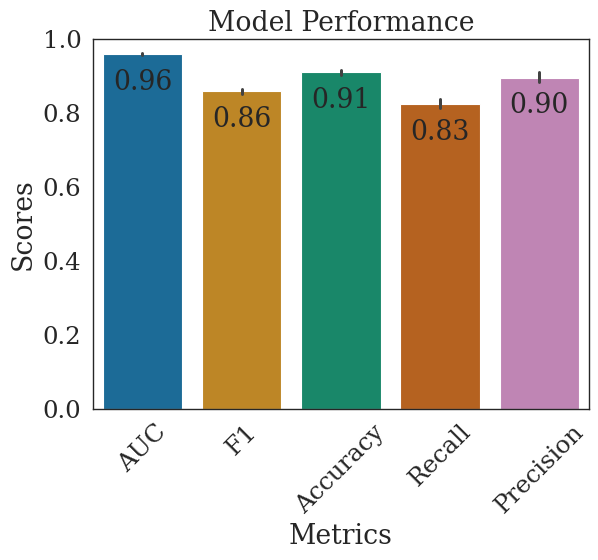

[16:47:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[16:47:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 8938/9078 [01:01<00:00]        

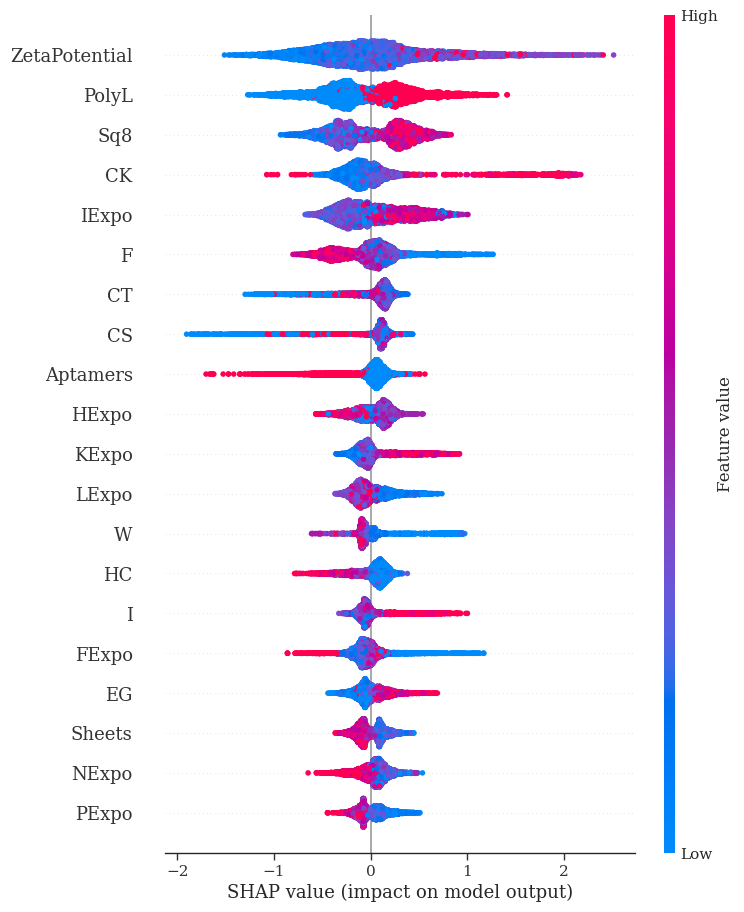

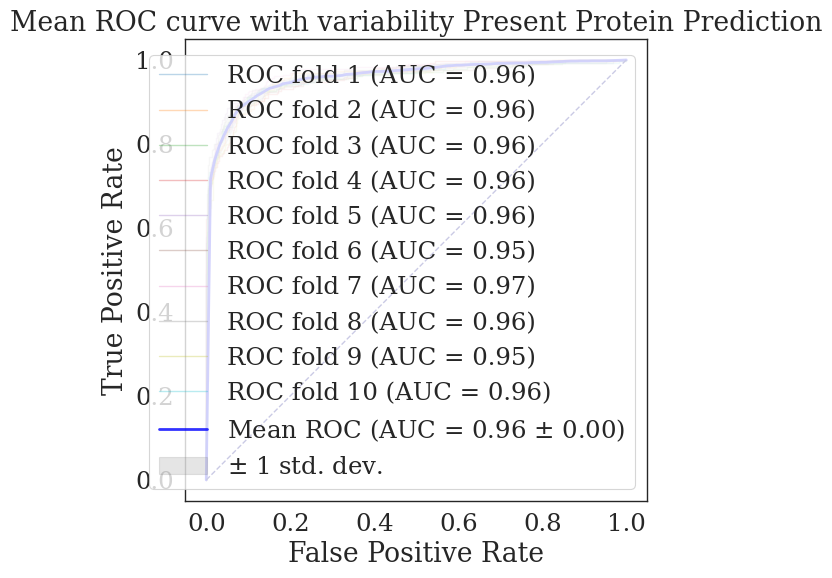

In [672]:
enrichStats,featureImportance,shaps =train_run_model(dataEnrich,abundance_Enrich,'Enrichment')

<Figure size 400x300 with 0 Axes>

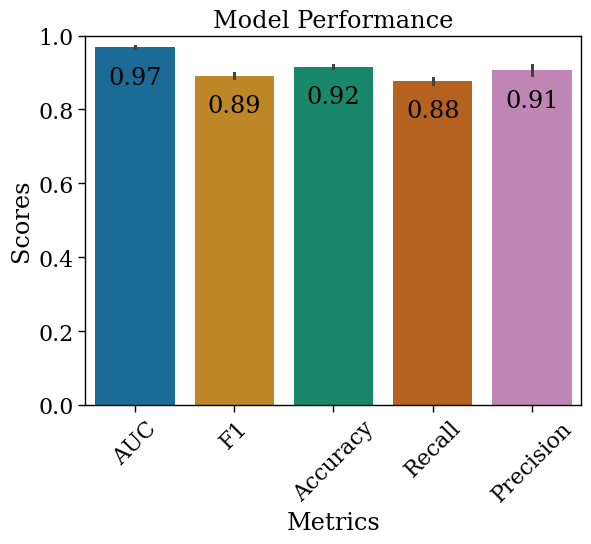

[15:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 99%|===================| 8948/9078 [00:56<00:00]        

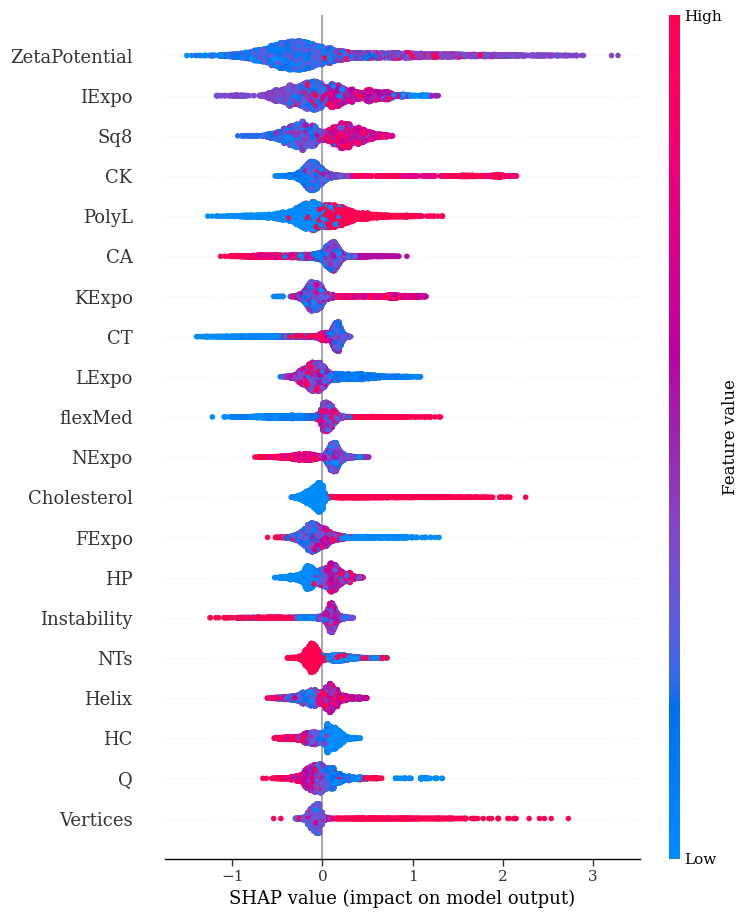

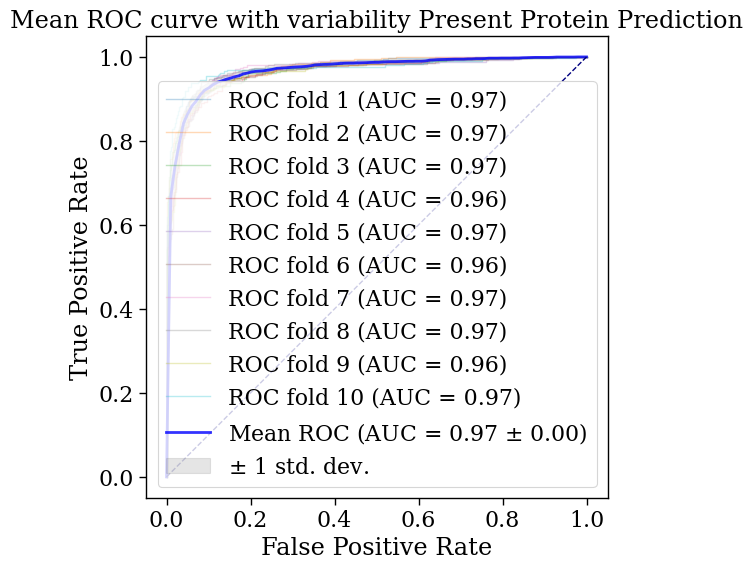

In [596]:
statsPres,featureImportancePres,shapsPres =train_run_model(dataPresent,abundance_present,'Present')

In [7]:
def getFeatureImportances(featureImportance, data):
    medianFeatures=featureImportance.median(axis =1)
    retFeatures=pd.DataFrame(medianFeatures)
    retFeatures.index = data.columns
    return retFeatures

In [83]:
enrichImportance=getFeatureImportances(featureImportance,dataEnrich)

In [100]:
presentImportance=getFeatureImportances(featureImportancePres,dataPresent)

In [101]:
presentImportance.to_csv('PresentFeatureImportance.csv')

In [84]:
enrichImportance.to_csv('EnrichedFeatureImportance.csv')

## Performance Across Subsets

In [679]:
def subset_data(inputArr,param):
    if(param == 'Origami'):
        outArr = inputArr[origami.columns]
    elif(param == 'Structure'):
        a2 = list(origami.columns)
        a2.append('Interactivity')
        a3 = list(functions.columns)
        a4=a2+a3
        outArr = inputArr.drop(np.array(a4),axis=1)
        return(outArr)
    elif(param == 'Functions'):
        a2 = list(functions.columns)
        a2.append('Interactivity')
        outArr=inputArr[a2]
    elif(param == 'All'):
        outArr = inputArr
    return(outArr)

In [680]:
def plotDataSubsets(dataPresent):
    Xstruct=subset_data(dataPresent,'Structure')
    Xfunct=subset_data(dataPresent,'Functions')
    Xorigami=subset_data(dataPresent,'Origami')

    structMet=train_run_model(Xstruct,abundance_present,'Structure')
    functMet=train_run_model(Xfunct,abundance_present,'Functional')
    origMet=train_run_model(Xorigami,abundance_present,'Origami')
    statsPres=train_run_model(dataPresent,abundance_present,'All')
    
    metricComparison=pd.concat([statsPres[0],origMet[0],functMet[0], structMet[0]])
    metricComparison.reset_index(drop=True, inplace = True)

    fig = plt.figure(figsize=(4, 3))
    plt.rc('font', family='serif')
    plt.rc('font', family='serif')
    plt.rc('xtick', labelsize='large')
    plt.rc('ytick', labelsize='large')
    g = sns.catplot(
        data=metricComparison, kind="bar",
        x="Model", y="Scores", hue="Metric", palette='colorblind', alpha=.6, height=6,saturation = .7
    )
    #g.despine(left=True)
    g.set(ylim=(0, 1), title='Performance Across Data Subsets')
    g.set_axis_labels("", "Score")
    plt.xticks(rotation=45)
    g.legend.set_title("")

<Figure size 400x300 with 0 Axes>

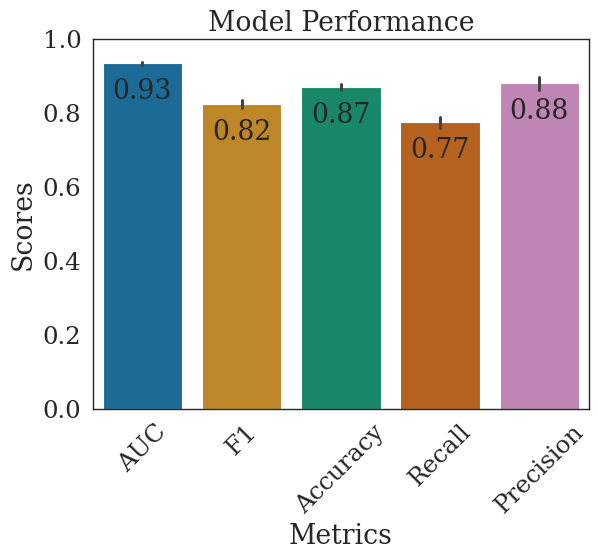

[16:54:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
[16:54:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 98%|===================| 8912/9078 [00:45<00:00]        

SystemError: <built-in function dense_tree_shap> returned a result with an exception set

In [681]:
plotDataSubsets(dataPresent)

## Functional Enrichment

In [695]:
def plotFunctionalEnrichment(dataDF,abundanceArray, functions):
    listVals = list()
    enrichVals = list()
    pVals = list()
    functs = list()
    pValDe = list()
    for z in functions:
        if(sum(dataDF[z]) > 390): # 23 or more proteins with the function
            funcArray=dataDF[z]
            functs.append(z)
            totSamples = len(abundanceArray)
            totfunctionalSamples = len(abundanceArray[funcArray == 1])
            totNonfunctionalSamples = len(abundanceArray[funcArray == 0])
            funcandAbundant = pd.DataFrame(abundanceArray)[funcArray == 1].value_counts()[1]
            totAbundant = pd.DataFrame(abundanceArray).value_counts()[1]
            defuncandAbundant = pd.DataFrame(abundanceArray)[funcArray == 0].value_counts()[1]
            pValDe.append(1-stats.hypergeom.cdf(defuncandAbundant-1, totSamples, totAbundant, totNonfunctionalSamples))
            enrichVals.append(funcandAbundant*totSamples/(totfunctionalSamples*totAbundant))
            pVals.append(1 - stats.hypergeom.cdf(funcandAbundant-1, totSamples, totAbundant, totfunctionalSamples))
            resArray = abundanceArray
            listVals.append(pd.DataFrame(abundanceArray)[funcArray == 1].value_counts()[1]/(pd.DataFrame(abundanceArray)[funcArray == 1].value_counts()[1] + pd.DataFrame(abundanceArray)[funcArray == 1].value_counts()[0]))


    pValSig = list()
    structSig = list()
    enrichSig = list()
    for z in range(len(pVals)):
        if(pVals[z]<0.05):
            pValSig.append(pVals[z])
            structSig.append(functs[z])
            enrichSig.append(enrichVals[z])

    for z in range(len(pValDe)):
        if(pValDe[z]<0.05):
            pValSig.append(pValDe[z])
            structSig.append(functs[z])
            enrichSig.append(enrichVals[z])

    functionalVals=pd.DataFrame({'Function':structSig,'Enrichment Value':enrichSig})
    funcVals2=functionalVals.transpose()
    funcVals2.columns = funcVals2.iloc[0]
    funcVals2.drop(['Function'], axis =0, inplace = True)
    funcVals2.sort_values(by = ['Enrichment Value'], axis = 1)

    ax = sns.barplot(data = funcVals2.sort_values(by = ['Enrichment Value'], axis = 1,ascending = False),orient='h')
    plt.axvline(1,linewidth=4, color='r')
    plt.title('Functional Protein Enrichment')
    #plt.yaxis('Enrichment Value')
    ax.set_xlabel('Enrichment Value')
    plt.plot()
    return(funcVals2.sort_values(by = ['Enrichment Value'], axis = 1,ascending = False))

iteritems is deprecated and will be removed in a future version. Use .items instead.


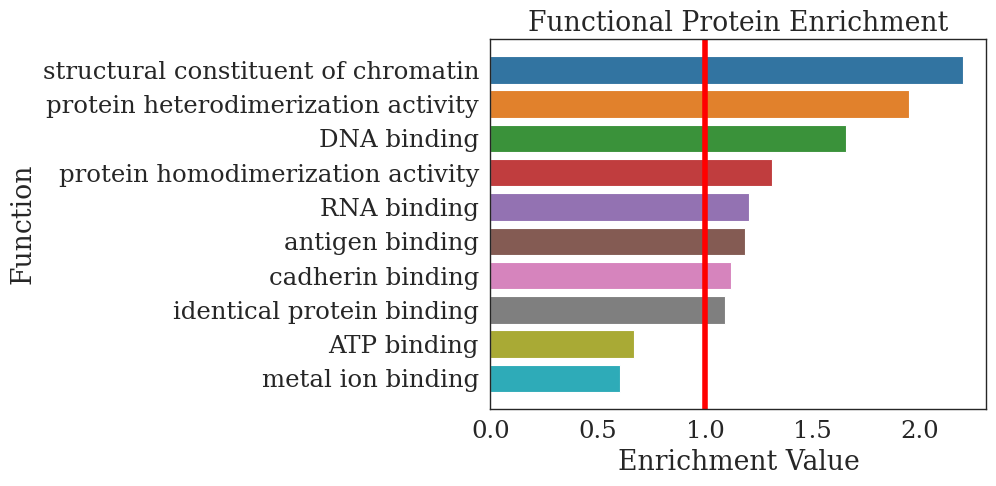

In [696]:
functionalTable=plotFunctionalEnrichment(dataPresent,abundance_present, functions)

In [580]:
functionalTable

Function         DNA binding RNA binding antigen binding cadherin binding  \
Enrichment Value    1.659866    1.207816        1.188662         1.122163   

Function         identical protein binding  \
Enrichment Value                  1.094732   

Function         protein heterodimerization activity  \
Enrichment Value                             1.95317   

Function         protein homodimerization activity  \
Enrichment Value                          1.310686   

Function         structural constituent of chromatin ATP binding  \
Enrichment Value                            2.202765    0.670305   

Function         metal ion binding  
Enrichment Value          0.605612

## Common Protein Sets

In [296]:
pd.DataFrame(np.asarray(resVals).reshape((len(listPros),len(listPros))), index =yVals, columns = yVals ) * 100

I-10        I-12        I-14        I-16
I-10  100.000000   66.666667   88.372093   91.428571
I-12   66.666667  100.000000   64.893617   65.463918
I-14   88.372093   64.893617  100.000000   90.909091
I-16   91.428571   65.463918   90.909091  100.000000

In [286]:
def commonProteins(listPros,overallRes3):
    allPros = np.unique(overallRes3['ID'])
    setNames = list()
    listSets = list()
    #for c in np.unique(overallRes3['Sample']):
    #for c in ['tube','tile','tensegrity','I-12']:
    #for c in ['tube','tile','tensegrity','I-12']:
    for c in listPros:
        subRes = overallRes3[overallRes3['Sample'] == c]
        subRes = subRes[subRes['Abundance'] == 1]
        listSets.append(set(subRes['ID']))
        setNames.append(c)

    setNums=pd.DataFrame([[e in setA for setA in listSets] for e in allPros], columns = setNames)

    yVals = list()
    xVals = list()
    resVals = list()
    for y in range(len(listSets)):
        for x in range(len(listSets)):
            if(x == y):
                resVals.append(1)
            else:
                common=listSets[x].intersection(listSets[y])
                totVals = listSets[x].union(listSets[y])
                resVals.append(len(common)/len(totVals))
            xVals.append(setNames[x])
        yVals.append(setNames[y])
        
    percentSim=pd.DataFrame(np.asarray(resVals).reshape((len(listPros),len(listPros))), index =yVals, columns = np.unique(xVals))
    percentSim = percentSim*100
    figsize=(6, 6)
    sns.set_context("paper", font_scale = 1.8)
    plt.rc('font', family='serif')
    cg = sns.clustermap(percentSim.loc[listPros,listPros], annot=True,cmap="Blues",fmt ='.0f',cbar_pos=(0, .4, .08, .4),annot_kws={"size": 8})
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_heatmap.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
    cg.ax_heatmap.set_yticklabels(cg.ax_heatmap.get_ymajorticklabels(), fontsize = 16)
    #plt.savefig('StructureCoronaSimilarityHeatmap.png',bbox_inches='tight')

    allPros = np.unique(overallRes3['ID'])
    df = pd.DataFrame([[e in setA for setA in listSets] for e in allPros], columns = setNames)
    df=df.loc[:,listPros]
    df_up = df.value_counts()
    fig1=upsetplot.UpSet(df_up,sort_by ='cardinality', min_degree = 1)
    #plot(fig1)
    fig1.plot()
    return pd.DataFrame(df_up)

### All Nanostructure

In [256]:
overallResPres=overallResPres.rename(columns={"Protein":'ID'})
overallResPres=overallResPres.rename(columns={"Present":'Abundance'})
dfAllCommon=commonProteins(np.unique(overallResPres['Sample']),overallResPres)

### PolyL Only

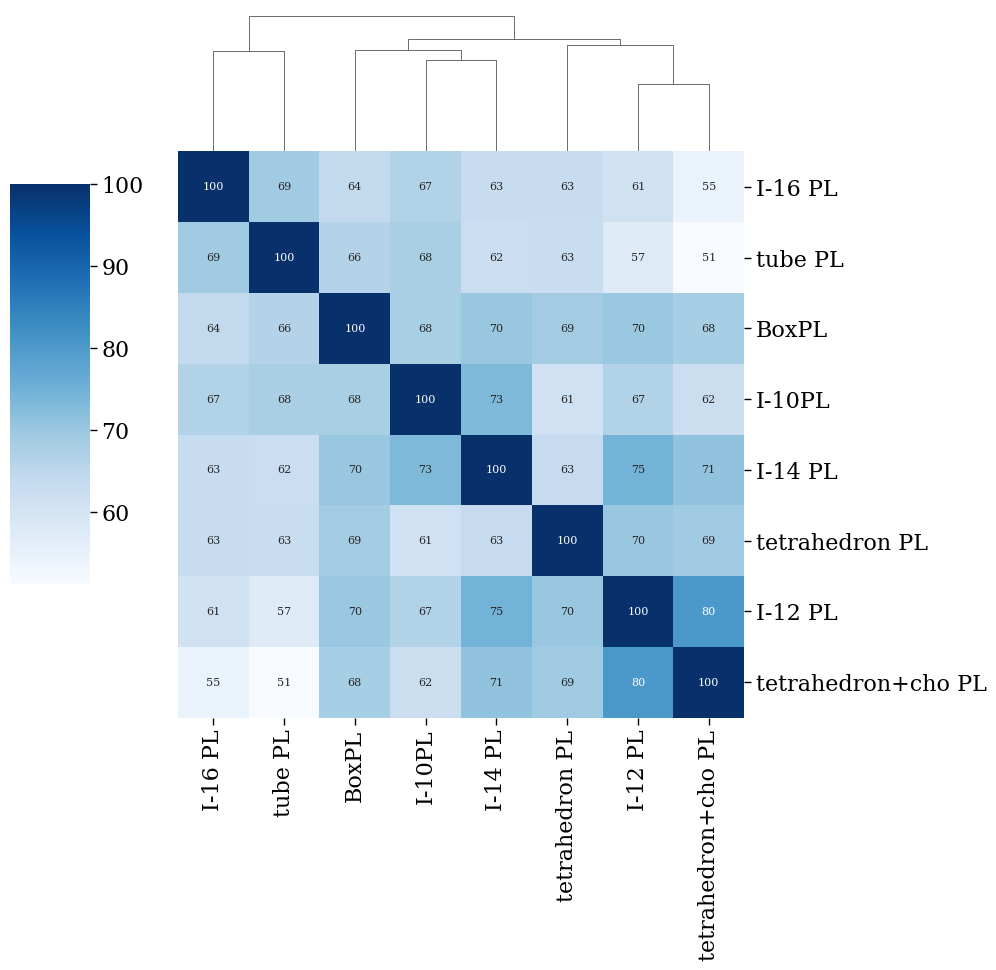

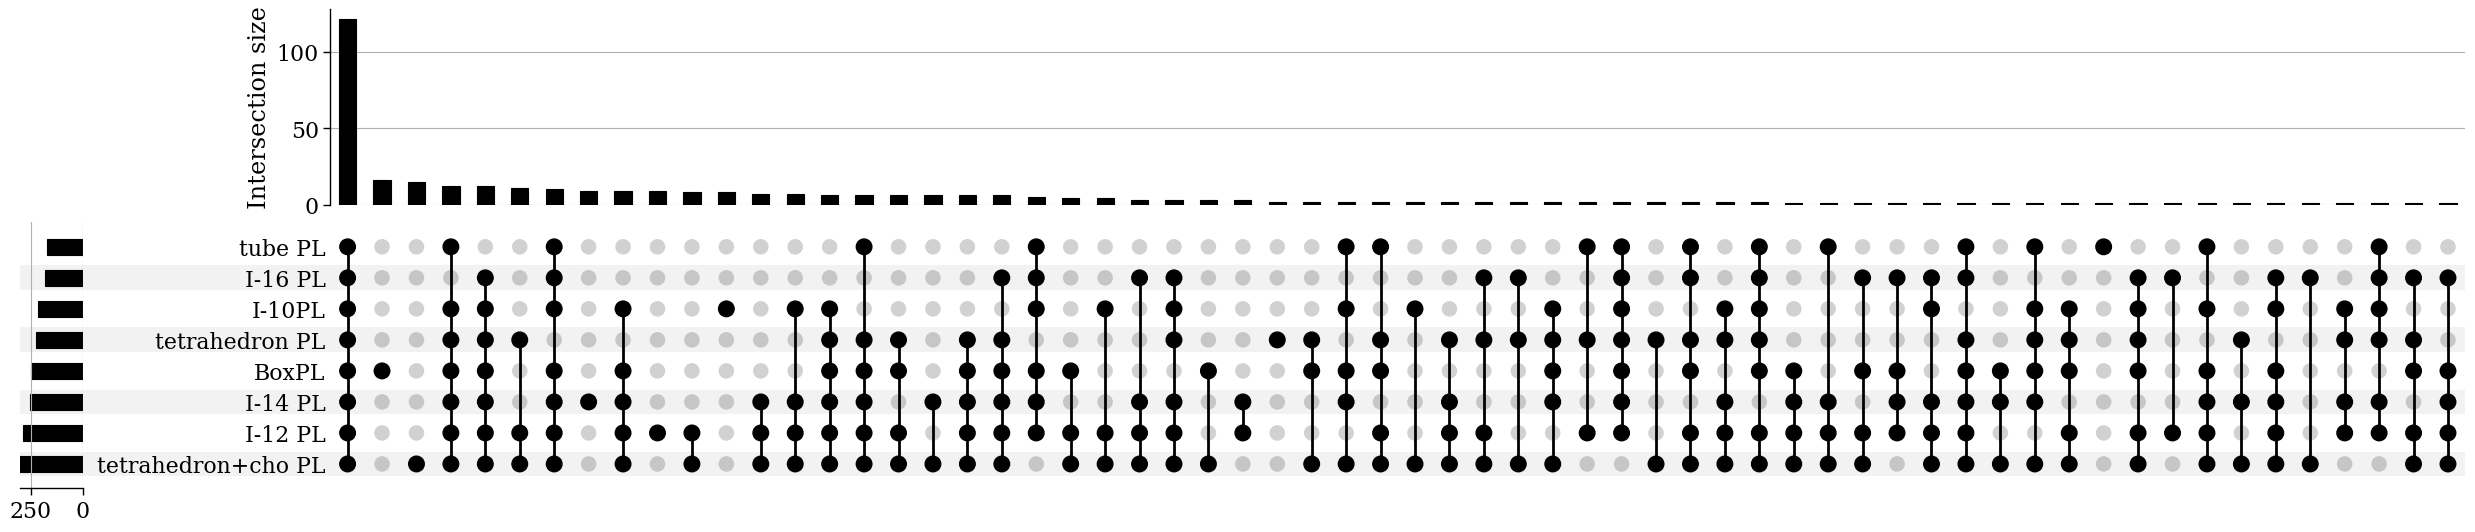

In [299]:
overallPL=overallResPres[overallResPres.Sample.str.contains("PL")]
dfAllPL=commonProteins(np.unique(overallPL['Sample']),overallPL)

### Bare Nanostructures

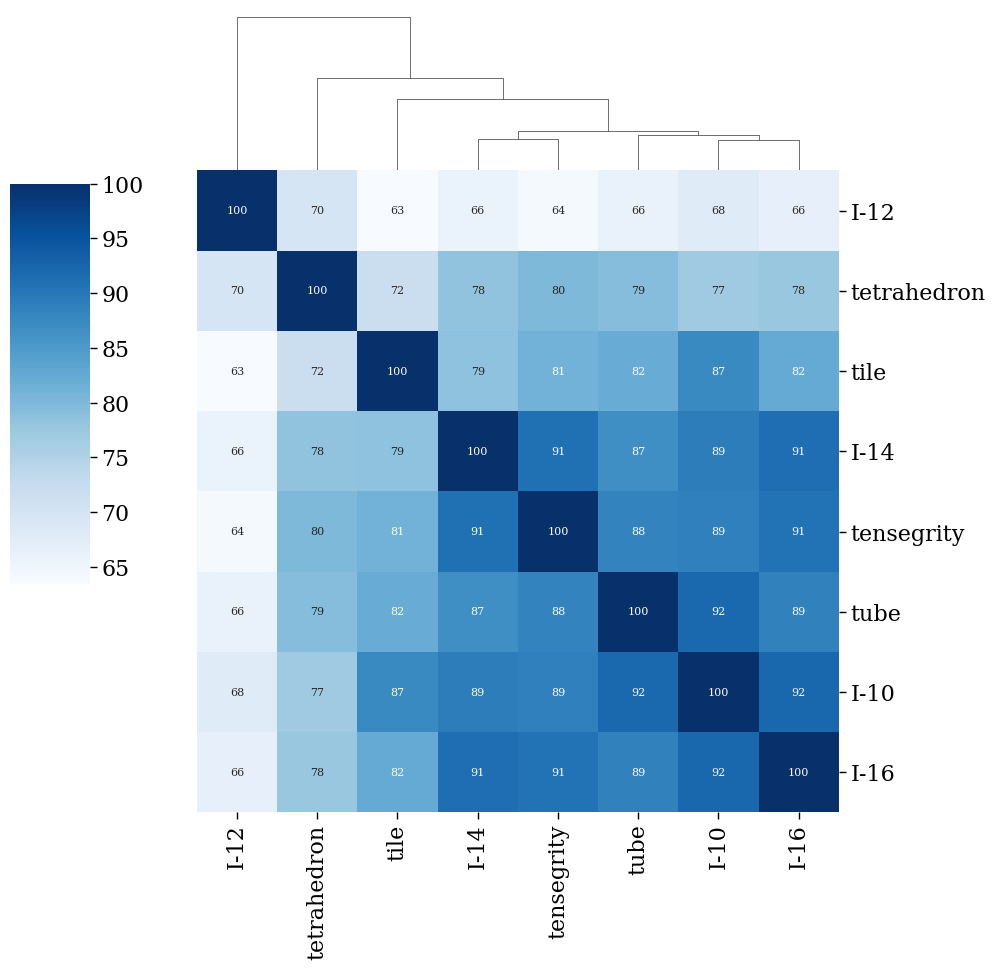

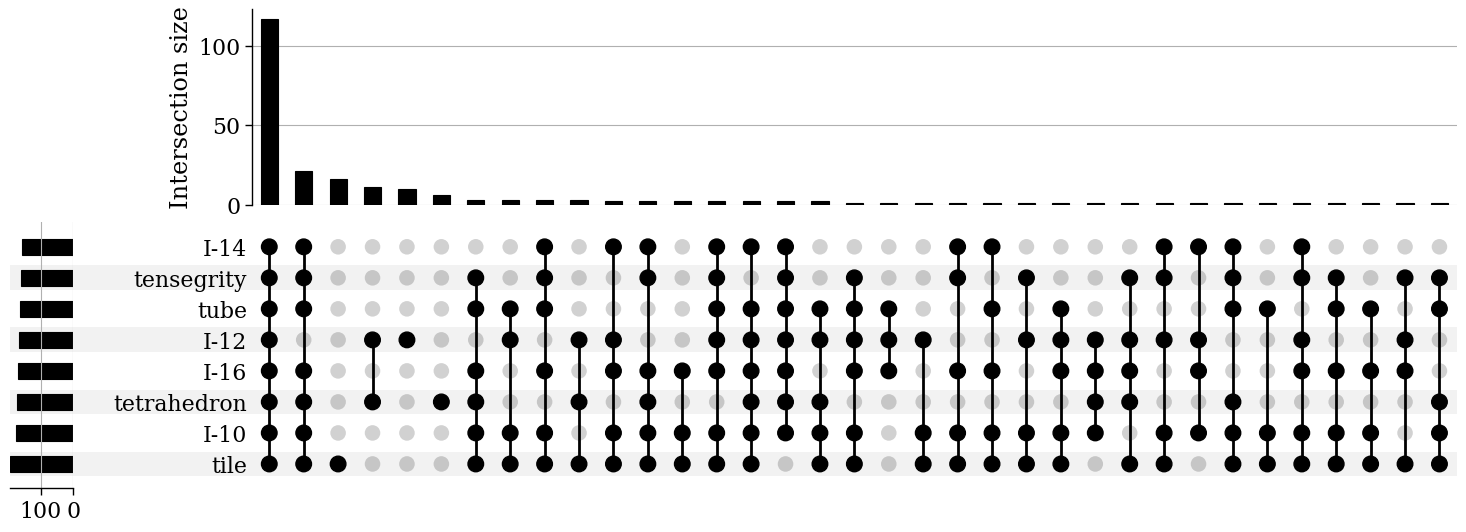

In [303]:
overallBare=overallResPres[~ overallResPres.Sample.str.contains("PL")]
overallBare=overallBare[~ overallBare.Sample.str.contains("cho")]
dfAllBare=commonProteins(np.unique(overallBare['Sample']),overallBare)

### Square Nanostructures

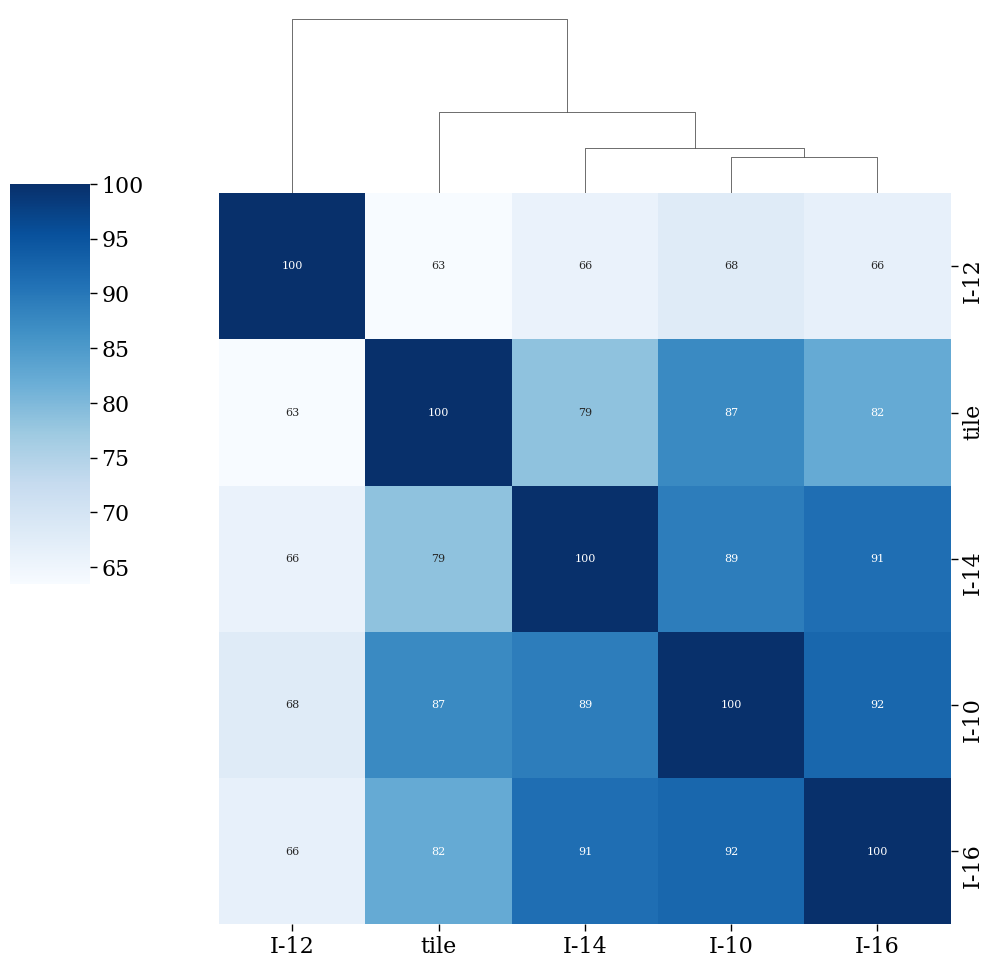

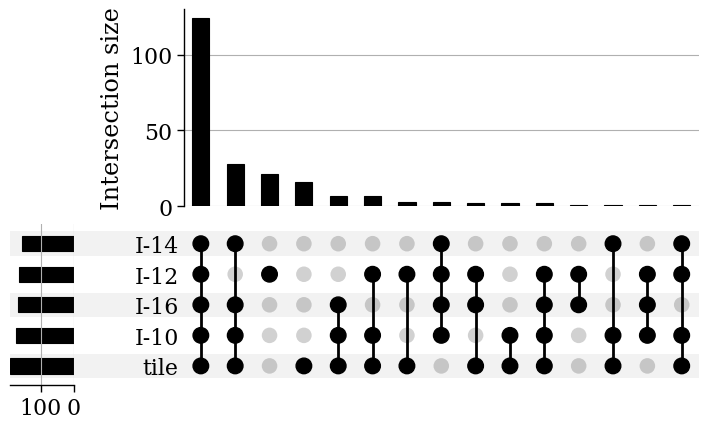

In [306]:
overall2D=overallResPres.loc[overallResPres['Sample'].isin(['tile','I-10','I-12','I-14','I-16'])]
df2D=commonProteins(np.unique(overall2D['Sample']),overall2D)

### 2d vs 3d

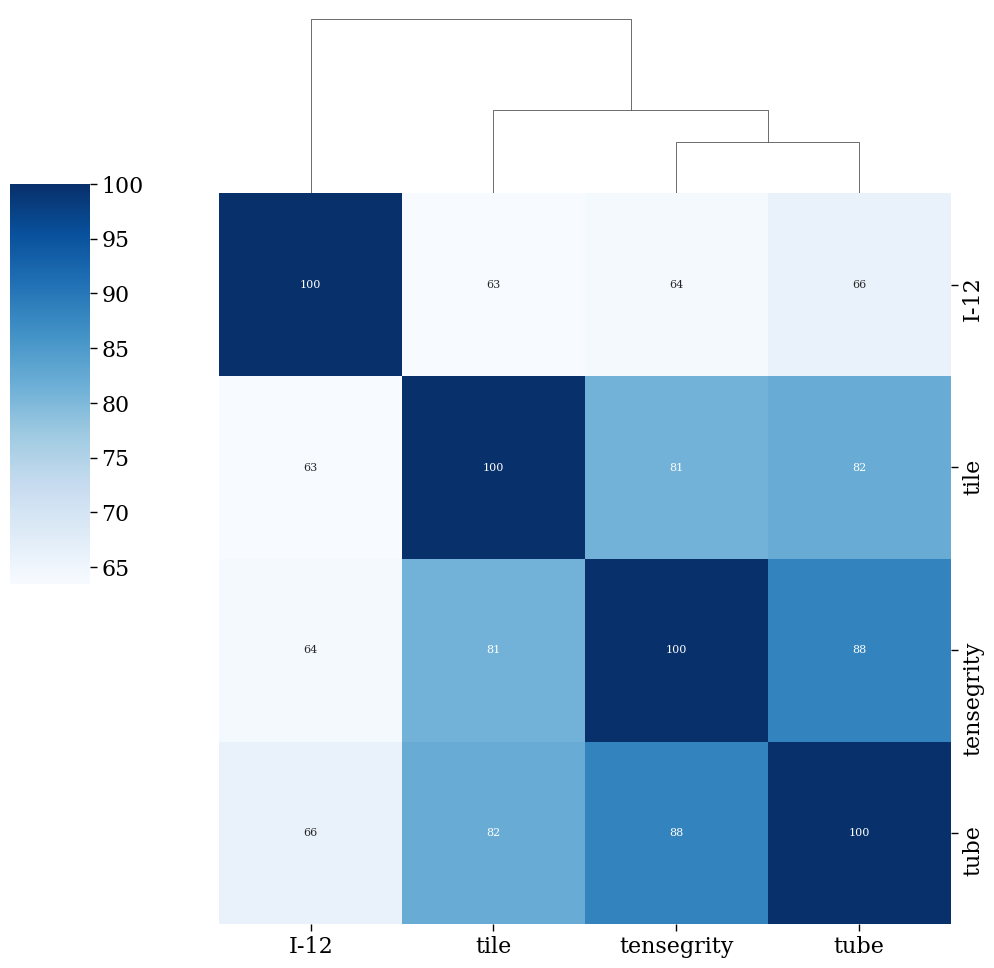

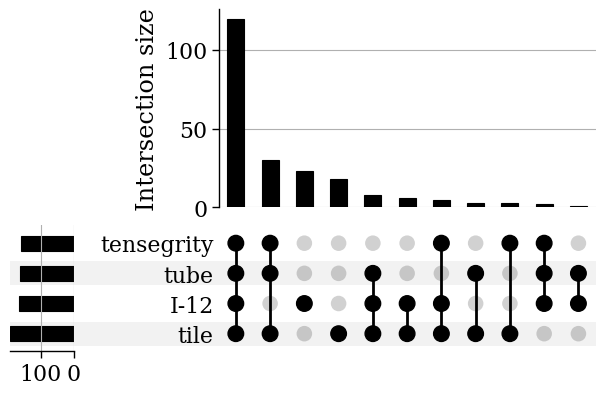

In [307]:
overallDimensions=overallResPres.loc[overallResPres['Sample'].isin(['tube','tensegrity','tile','I-12'])]
dfDimensions=commonProteins(np.unique(overallDimensions['Sample']),overallDimensions)

## Differential Protein Properties

In [493]:
proDatabase=pd.read_csv('ProStatistics8_4.csv')
proDatabase.index = proDatabase['Unnamed: 0']
proDatabase.drop('Unnamed: 0', axis =1, inplace = True)

### Proteins Universally Present and Absent

In [345]:
set(pd.read_csv("C:\\Users\\jared\\Downloads\\UpdatedProteinDatabase2_5.csv")['Protein']).difference(set(overallResPres['ID']))

{'P01023', 'P60673', 'Q96L08', 'Q9NR31', 'Q9Y6B6'}

P01023 = Alpha-2-macroglobulin 
P07737=profilin1
Q6UWL2=Sushi domain-containing protein1
Q9NR31 = GTP-binding protein SAR1a
Q9Y6B6=GTP-binding protein SAR1b  

In [375]:
Translate[Translate['Old'] == 'GTP-binding protein SAR1b '] #WRONG

Empty DataFrame
Columns: [Old, New]
Index: []

In [496]:
proDatabase['DNA binding'].value_counts()

0    495
1     32
Name: DNA binding, dtype: int64

In [346]:
set(overallResPres['ID']).difference(set(pd.read_csv("C:\\Users\\jared\\Downloads\\UpdatedProteinDatabase2_5.csv")['Protein']))

{'P35080'}

In [347]:
len(set(overallResPres['ID']))

527

In [322]:
pros = np.unique(overallResPres['ID'])
presPros = list()
absentPros = list()
for pro in pros:
    subRes=overallResPres[overallResPres['ID']==pro]
    if(subRes['Abundance'].sum() == 17):
        presPros.append(pro)
    elif(subRes['Abundance'].sum() == 0):
        absentPros.append(pro)

In [325]:
len(absentPros)

120

In [326]:
len(presPros)

114

In [328]:
pd.DataFrame(absentPros).to_csv('NegProteins.csv')
pd.DataFrame(presPros).to_csv('PosProteins.csv')

### Proteins Universally Absent

In [334]:
allposPros=pd.read_csv('PosProteins.csv')

In [336]:
allposPros.iloc[:,1]

0      A0A0A0MRZ8
1      A0A0C4DH30
2      A0A0C4DH35
3      A0A0J9YX35
4      A0A0J9YXX1
          ...    
109        Q9BQE3
110        Q9BTM1
111        Q9UL12
112        Q9ULI0
113        Q9Y281
Name: 0, Length: 114, dtype: object

In [490]:
compPlot

Values   Variables   Protein Group
0      0.139130  Net Charge  0.000000  Bulk
1      0.213675  Net Charge  0.000000  Bulk
2      0.162393  Net Charge  0.000000  Bulk
3      0.162393  Net Charge  0.000000  Bulk
4      0.153846  Net Charge  0.000000  Bulk
...         ...         ...       ...   ...
7717 -77.825264     phiMean  0.003197  Size
7718 -72.260158     phiMean  0.015510  Size
7719 -79.663911     phiMean  0.010101  Size
7720 -81.276870     phiMean  0.004484  Size
7721 -79.376462     phiMean  0.004165  Size

[7722 rows x 4 columns]

In [491]:
count

33

In [497]:
datasets

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0089686098654708,
 0.0058997050147492,
 0.0,
 0.0,
 0.0073529411764705,
 0.0,
 0.0,
 0.008695652173913,
 0.003012048192771,
 0.0062893081761006,
 0.0,
 0.0,
 0.0,
 0.0031545741324921,
 0.0,
 0.0,
 0.0018975332068311,
 0.0,
 0.0031055900621118,
 0.0,
 0.0046082949308755,
 0.0,
 0.0048543689320388,
 0.0067567567567567,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0034904013961605,
 0.0046439628482972,
 0.0,
 0.0029623360135421,
 0.0046620046620046,
 0.0079744816586921,
 0.0093959731543624,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0060240963855421,
 0.0018083182640144,
 0.0068649885583524,
 0.005050505050505,
 0.0,
 0.0092764378478664,
 0.0043196544276457,
 0.0,
 0.0,
 0.0040160642570281,
 0.0026666666666666,
 0.008130081300813,
 0.0337837837837837,
 0.0037593984962406,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0026666666666666,
 0.0088691796008869,
 0.0147058823529411,
 0.0,
 0.0073529411764705,
 0.0028598665395614,
 0.0,
 0.0100502512562814,
 0.0011185682326621,
 0.0,
 0

In [501]:
valCols = list()
variables = list()
datasets = list()
for z in range(len(compSmall.columns)):
    if(compSmall.columns[z] != 'Dummy' and compSmall.columns[z] !='Dataset'):
        for a in range(len(compSmall)):
            valCol=compSmall.iloc[a,z]
            variable = compSmall.columns[z]
            datasetName = compSmall.loc[a,'Dataset']
            valCols.append(valCol)
            variables.append(variable)
            datasets.append(datasetName)

In [502]:
datasetName

'Absent'

In [509]:
np.unique(compPlot['Variables'])

array(['Aromaticity', 'C', 'CC', 'CExpo', 'CK', 'CL', 'CP', 'CW',
       'DNA binding', 'F', 'FExpo', 'HC', 'HN', 'HR', 'IsoelectricPoint',
       'K', 'KExpo', 'L', 'LExpo', 'LengthAminoAcids', 'Molecular Weight',
       'Net Charge', 'Neutral Charge', 'P', 'PExpo', 'W', 'WExpo',
       'flexMed', 'flexMin', 'nucleosomal DNA binding', 'phiMean',
       'protein heterodimerization activity',
       'structural constituent of chromatin'], dtype=object)

In [512]:
compPlot

Values   Variables  Protein
0      0.139130  Net Charge  Present
1      0.213675  Net Charge  Present
2      0.162393  Net Charge  Present
3      0.162393  Net Charge  Present
4      0.153846  Net Charge  Present
...         ...         ...      ...
7717 -77.825264     phiMean   Absent
7718 -72.260158     phiMean   Absent
7719 -79.663911     phiMean   Absent
7720 -81.276870     phiMean   Absent
7721 -79.376462     phiMean   Absent

[7722 rows x 3 columns]

In [516]:
compPlot.loc[~compPlot['Variables'].isin(remove)]

Values   Variables  Protein
0     0.139130  Net Charge  Present
1     0.213675  Net Charge  Present
2     0.162393  Net Charge  Present
3     0.162393  Net Charge  Present
4     0.153846  Net Charge  Present
...        ...         ...      ...
7483  0.004796          CW   Absent
7484  0.001633          CW   Absent
7485  0.000000          CW   Absent
7486  0.002990          CW   Absent
7487  0.005090          CW   Absent

[6318 rows x 3 columns]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

['DNA binding' 'Neutral Charge' 'nucleosomal DNA binding' 'phiMean'
 'protein heterodimerization activity'
 'structural constituent of chromatin']


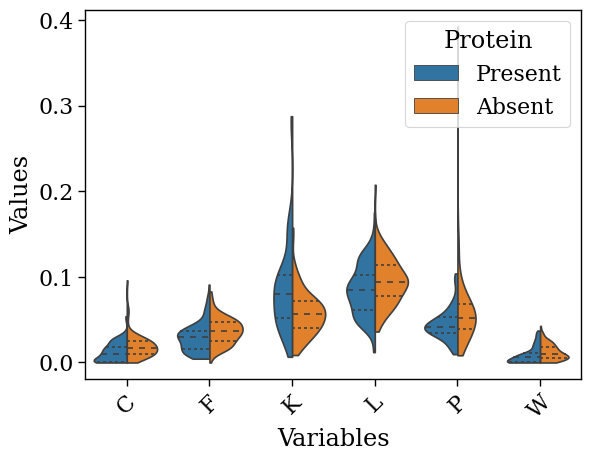

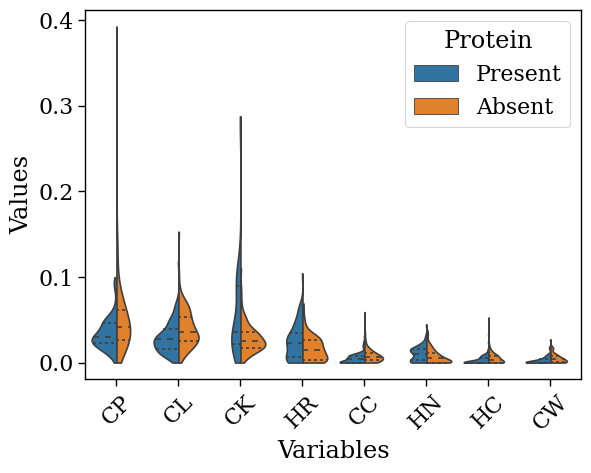

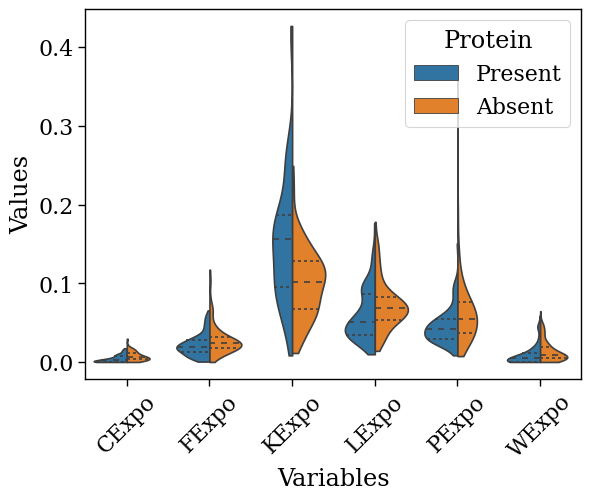

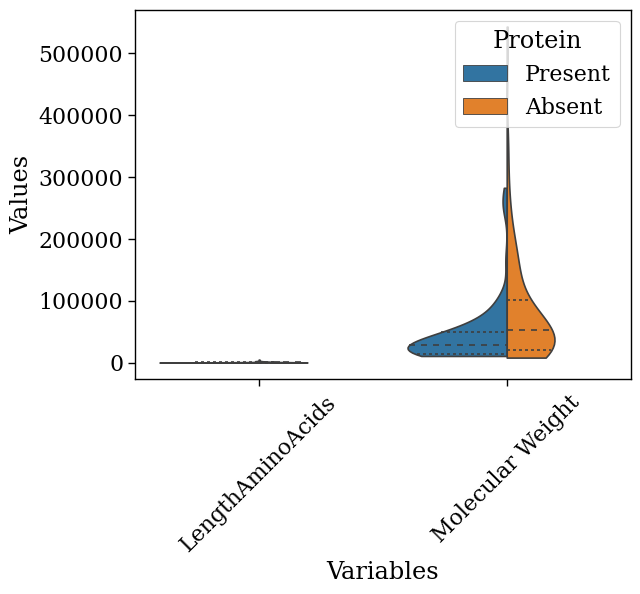

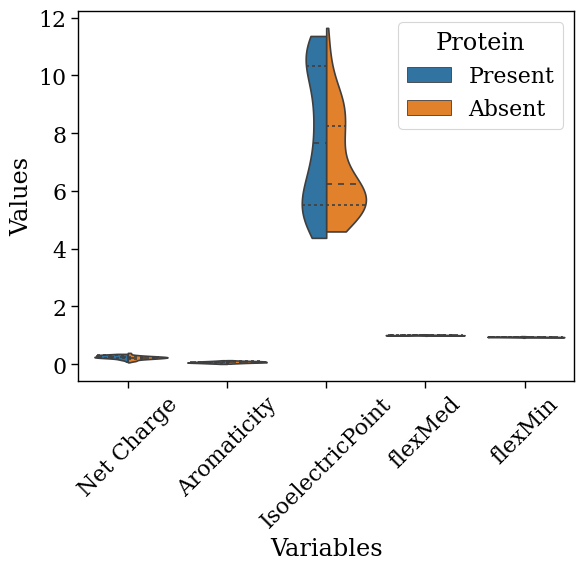

In [518]:
#proDatabase=pd.read_csv("C:\\Users\\jared\\Downloads\\UpdatedProteinDatabase2_5.csv")
allposPros=pd.read_csv('PosProteins.csv')
allnegPros=pd.read_csv('NegProteins.csv')
allposPros=allposPros.iloc[:,1].values
allnegPros=allnegPros.iloc[:,1].values

posproData=proDatabase.loc[allposPros]
negproData=proDatabase.loc[allnegPros]

posproData['Dataset'] = 'Present'
negproData['Dataset'] = 'Absent'

comparison=pd.concat([posproData,negproData], ignore_index = True)
comparison['Dummy'] = 0
pVals = list()
zVals = list()
count = 0
for z in comparison.columns:
    if(z != 'Dataset'):
        if(z !='Dummy'):
            zVals.append(z)
            pVals.append(stats.ttest_ind(comparison[comparison['Dataset'] == 'Present'][z], comparison[comparison['Dataset'] == 'Absent'][z], equal_var = False)[1])
            if(stats.ttest_ind(comparison[comparison['Dataset'] == 'Present'][z], comparison[comparison['Dataset'] == 'Absent'][z], equal_var = False)[1] < .01):
                count = count+1
                
pvalDF=pd.DataFrame(pVals, index = zVals)
pVal=pvalDF.sort_values(by=0)
compSmall=comparison[comparison.columns.intersection(list(pVal[pVal.iloc[:,0] < .01].index))]
#compSmall.drop(['antigen binding'], axis = 1, inplace = True)
compSmall['Dataset'] = comparison['Dataset']
compSmall['Dummy'] = 0
valCols = list()
variables = list()
datasets = list()
for z in range(len(compSmall.columns)):
    if(compSmall.columns[z] != 'Dummy' and compSmall.columns[z] !='Dataset'):
        for a in range(len(compSmall)):
            valCol=compSmall.iloc[a,z]
            variable = compSmall.columns[z]
            datasetName = compSmall.loc[a,'Dataset']
            valCols.append(valCol)
            variables.append(variable)
            datasets.append(datasetName)
compPlot=pd.DataFrame({'Values':valCols,'Variables':variables,'Protein':datasets})

pVal=pvalDF.sort_values(by=0)

compSmall=comparison[comparison.columns.intersection(list(pVal[pVal.iloc[:,0] < .01].index))]
compSmall['Dummy'] = 0
compSmall['Dataset'] = comparison['Dataset']

valCols = list()
variables = list()
datasets = list()
for z in range(len(compSmall.columns)):
    if(compSmall.columns[z] != 'Dummy' and compSmall.columns[z] !='Dataset'):
        #if(compSmall.columns[z] in pVal[0:13].index):
        for a in range(len(compSmall)):
            valCol=compSmall.iloc[a,z]
            variable = compSmall.columns[z]
            datasetName = compSmall.loc[a,'Dataset']
            valCols.append(valCol)
            variables.append(variable)
            datasets.append(datasetName)
            
compPlot=pd.DataFrame({'Values':valCols,'Variables':variables,'Protein':datasets})

group = list()
remove = list()
for z in range(len(compPlot)):
    var = compPlot.loc[z,'Variables']
    if(len(var) == 5):
        group.append('ExposedAminoAcid')
    elif(len(var) == 1):
        group.append('SingleAminoAcid')
    elif(len(var) == 2):
        group.append('AminoSecondaryStructure')
    elif((var == 'flexMin') or (var == 'Net Charge') or (var == 'Aromaticity')or (var=='flexMed') or (var =='IsoelectricPoint')):
        group.append('Bulk')
    elif((var == 'Molecular Weight') or (var == 'LengthAminoAcids')):
        group.append('Size')
    else:
        remove.append(var)
print(np.unique(remove))
compPlot = compPlot.loc[~compPlot['Variables'].isin(remove)]
compPlot.reset_index(drop=True, inplace = True)        
compPlot['Group'] = group

sns.violinplot(data=compPlot[compPlot['Group']=='SingleAminoAcid'], x='Variables', hue='Protein', y='Values', split=True,inner = 'quart', cut = 0, pallete = 'colorblind')

plt.xticks(rotation=45)
#plt.savefig('SingleAminoAcid_PresvsAbsent.png',bbox_inches='tight')
#plt.clf()
plt.show()

sns.violinplot(data=compPlot[compPlot['Group']=='AminoSecondaryStructure'], x='Variables', hue='Protein', y='Values', split=True,inner = 'quart', cut = 0, pallete = 'colorblind')
plt.xticks(rotation=45)
#plt.savefig('SecondaryAcid_PresvsAbsent.png',bbox_inches='tight')
#plt.clf()
plt.show()

sns.violinplot(data=compPlot[compPlot['Group']=='ExposedAminoAcid'], x='Variables', hue='Protein', y='Values', split=True,inner = 'quart', cut = 0, pallete = 'colorblind')
plt.xticks(rotation=45)
#plt.savefig('ExposedAminoAcid_PresvsAbsent.png',bbox_inches='tight')
#plt.clf()
plt.show()

sns.violinplot(data=compPlot[compPlot['Group']=='Size'], x='Variables', hue='Protein', y='Values', split=True,inner = 'quart', cut = 0, pallete = 'colorblind')
plt.xticks(rotation=45)
#plt.savefig('SecondaryStructure_PresvsAbsent.png',bbox_inches='tight')
#plt.clf()
plt.show()

sns.violinplot(data=compPlot[compPlot['Group']=='Bulk'], x='Variables', hue='Protein', y='Values', split=True,inner = 'quart', cut = 0, pallete = 'colorblind')
plt.xticks(rotation=45)
#plt.savefig('Bulk_PresvsAbsent.png',bbox_inches='tight')
plt.show()


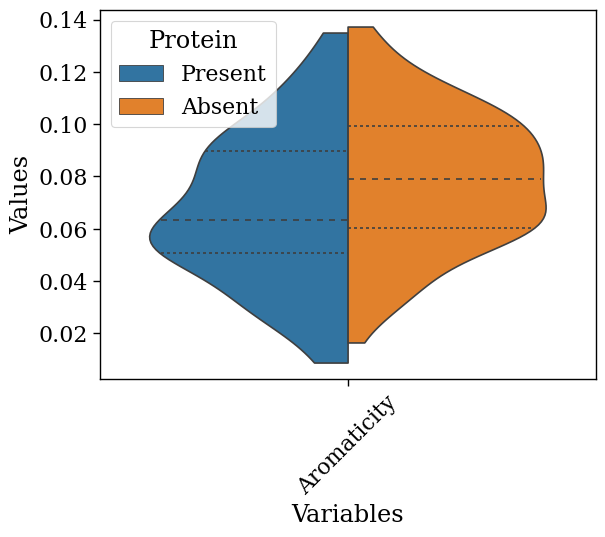

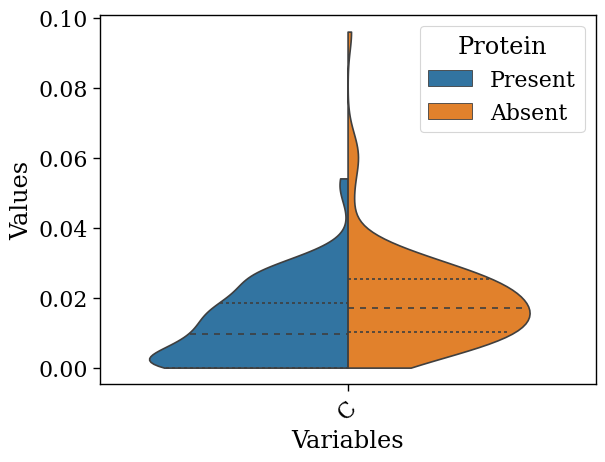

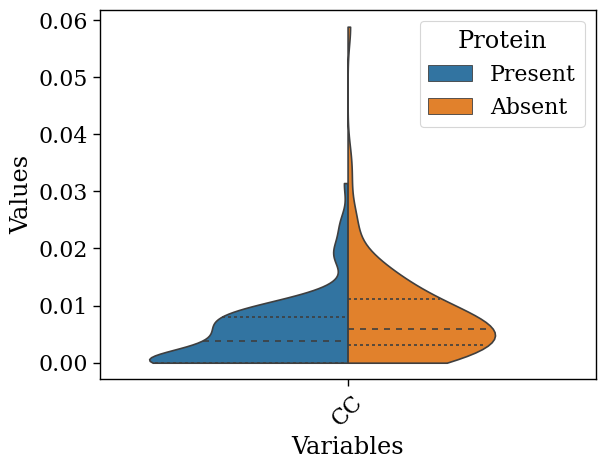

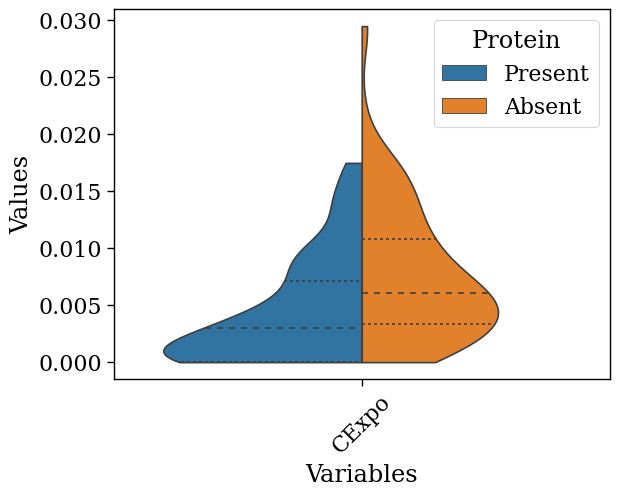

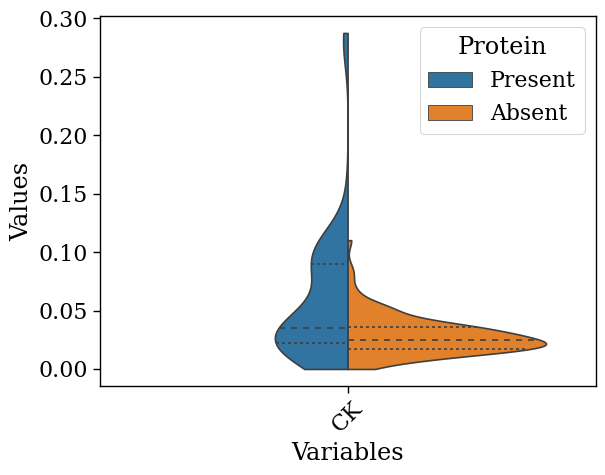

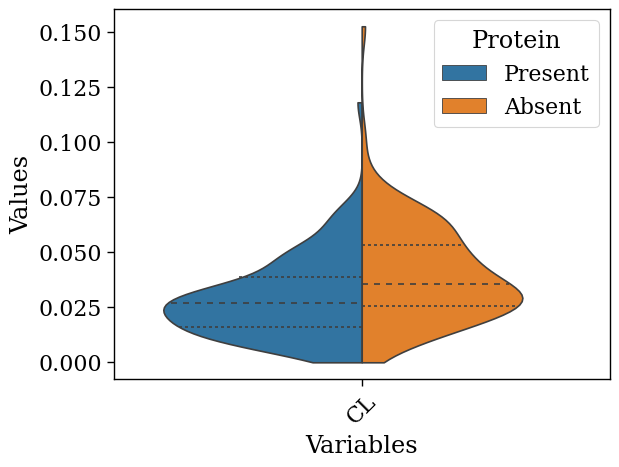

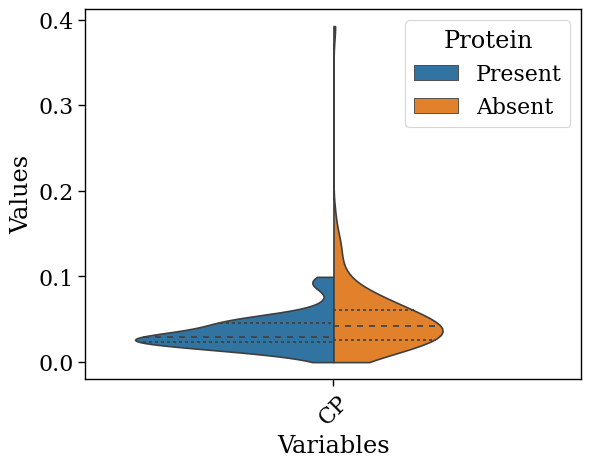

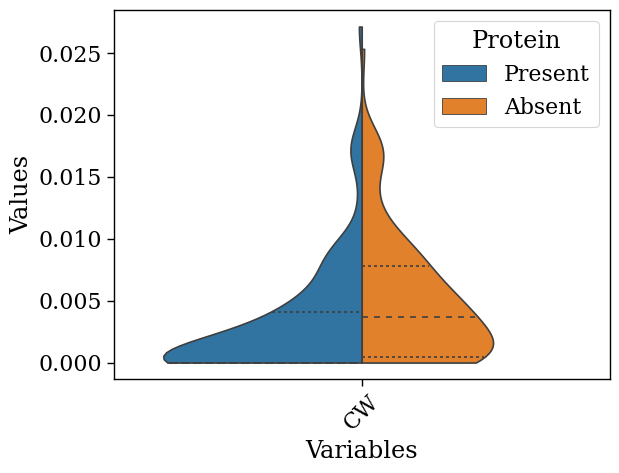

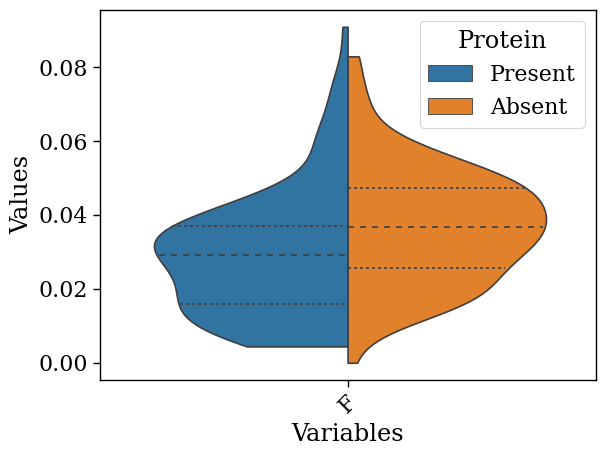

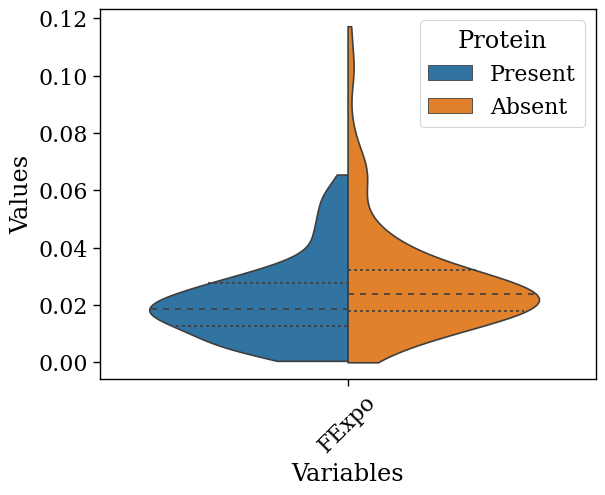

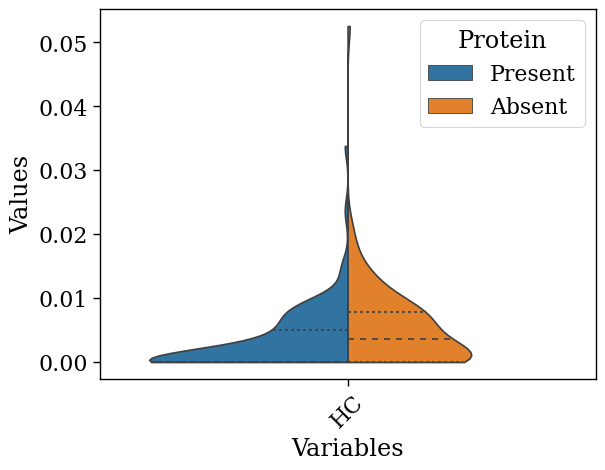

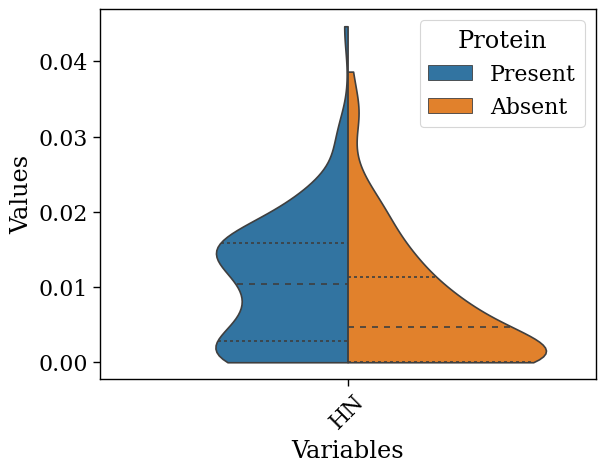

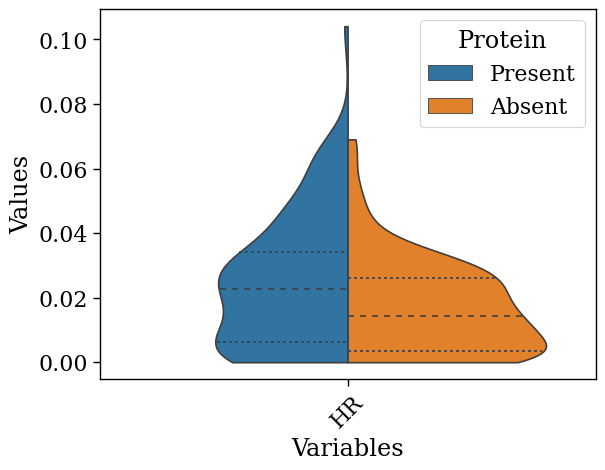

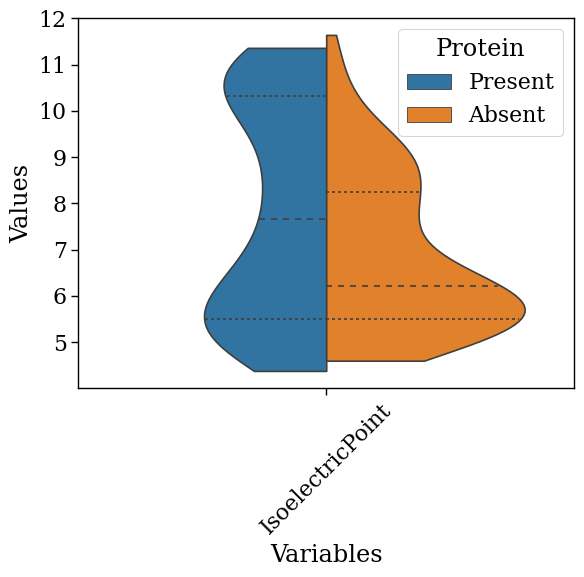

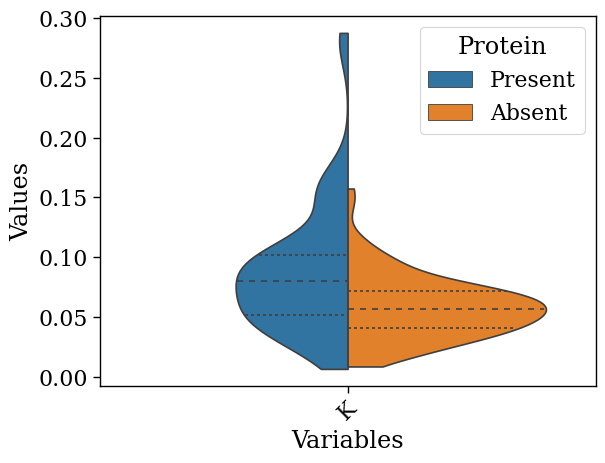

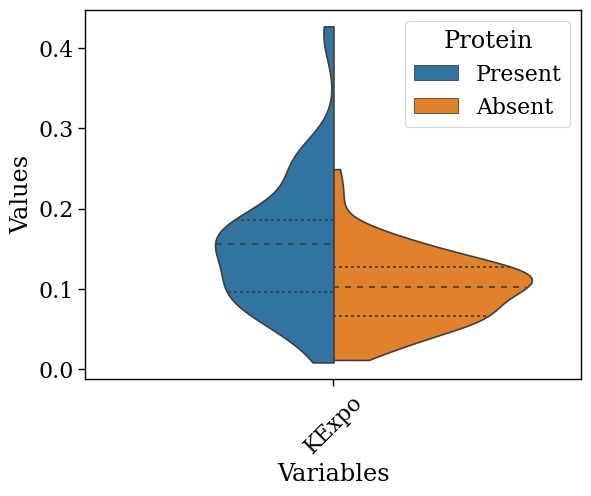

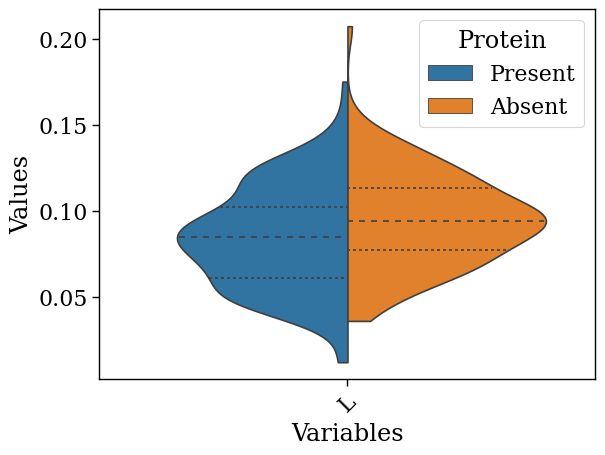

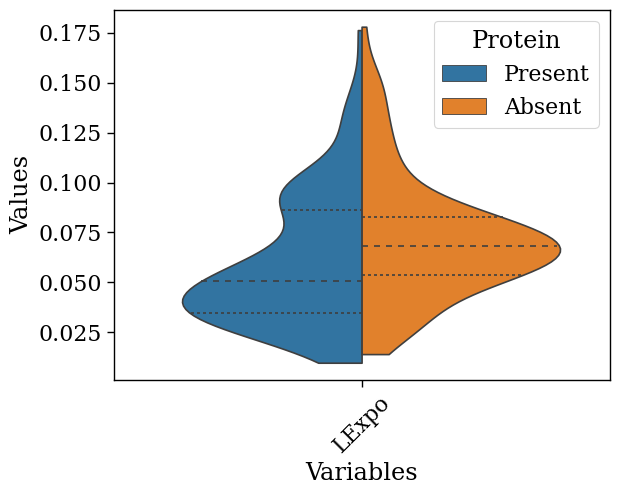

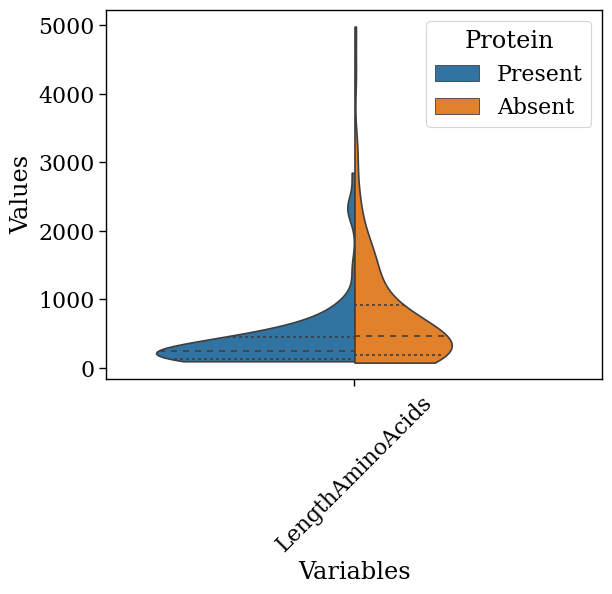

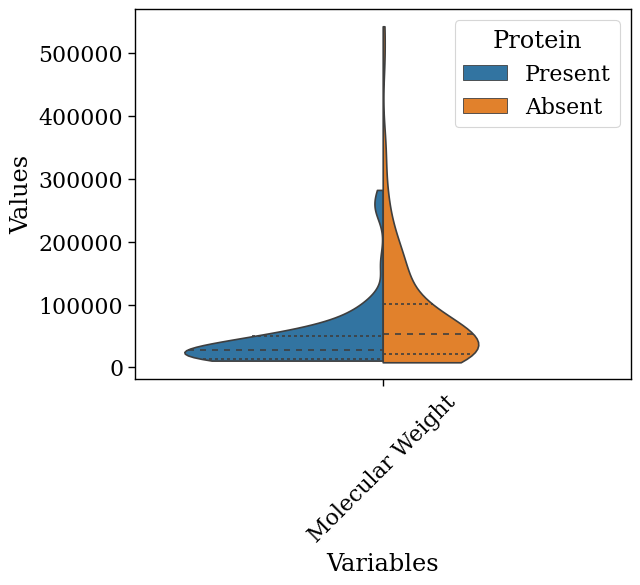

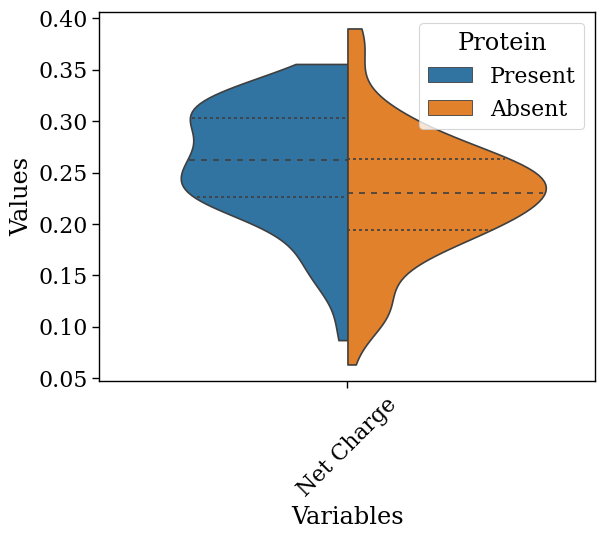

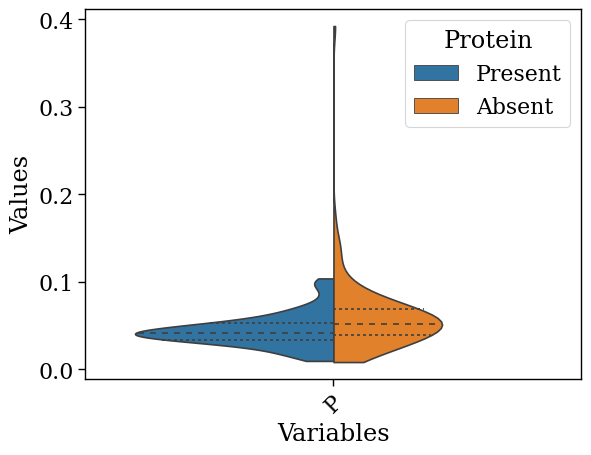

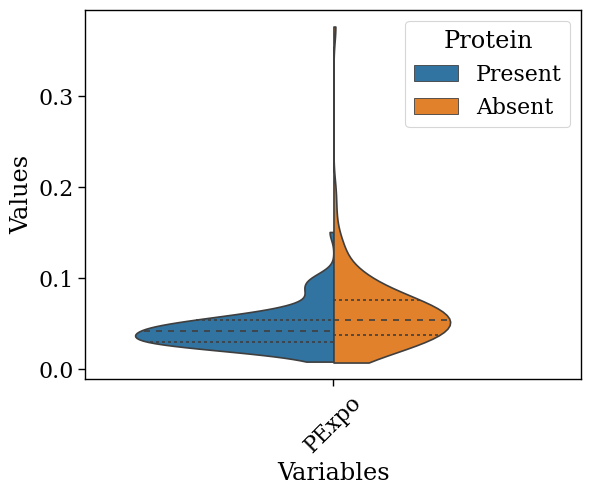

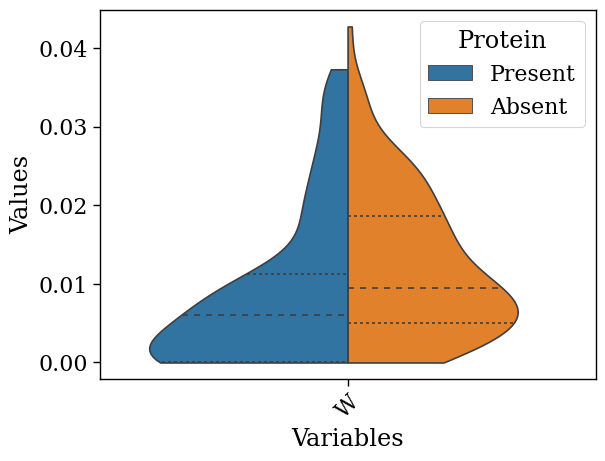

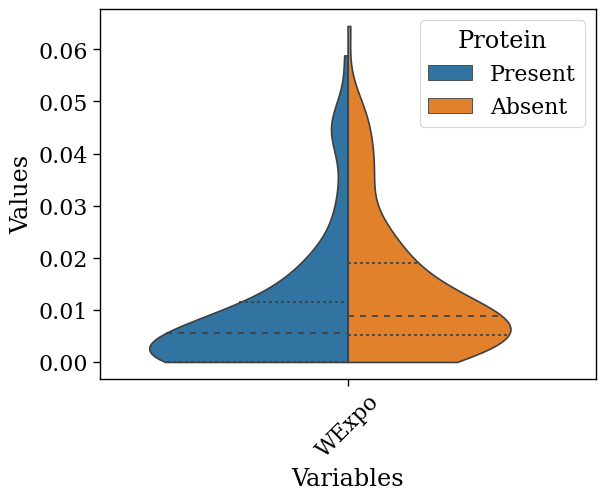

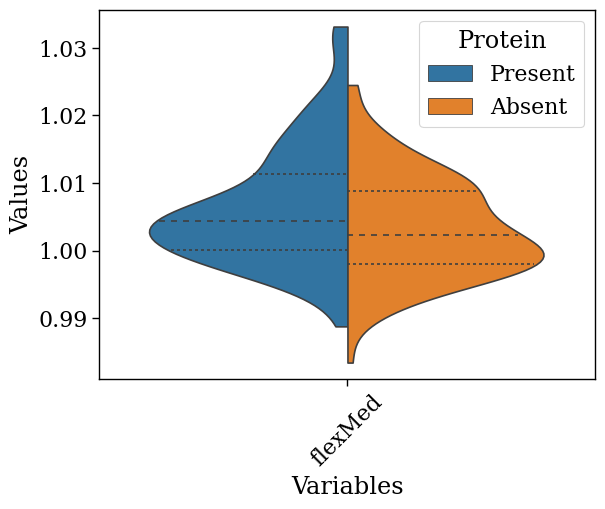

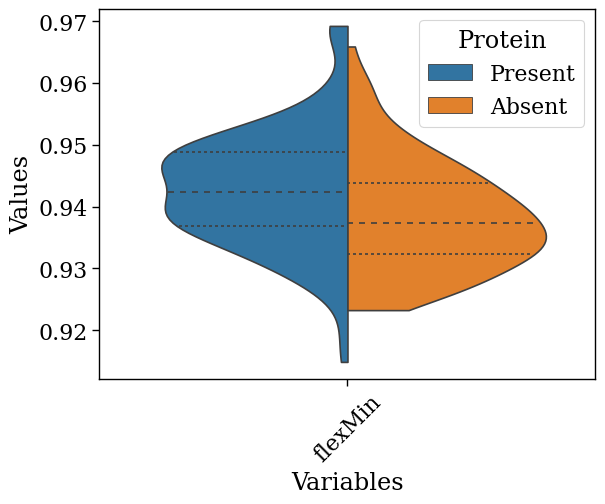

In [519]:
vars1=np.unique(compPlot['Variables'])
for var in vars1:
    sns.violinplot(data=compPlot[compPlot['Variables']==var], x='Variables', hue='Protein', y='Values', split=True,inner = 'quart', cut = 0, pallete = 'colorblind')
    plt.xticks(rotation=45)
    #plt.savefig('Bulk_PresvsAbsent.png',bbox_inches='tight')
    plt.show()

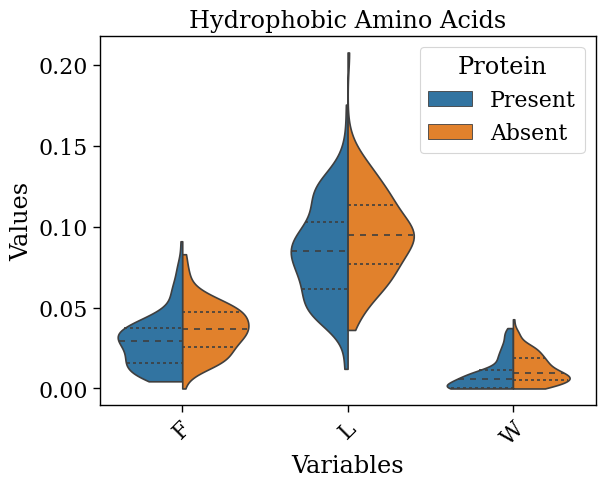

In [524]:
sns.violinplot(data=compPlot[compPlot['Variables'].isin(['L','F','W'])], x='Variables', hue='Protein', y='Values', split=True,inner = 'quart', cut = 0, pallete = 'colorblind')
plt.xticks(rotation=45)
plt.title('Hydrophobic Amino Acids')
#plt.savefig('SecondaryStructure_PresvsAbsent.png',bbox_inches='tight')
#plt.clf()
plt.show()

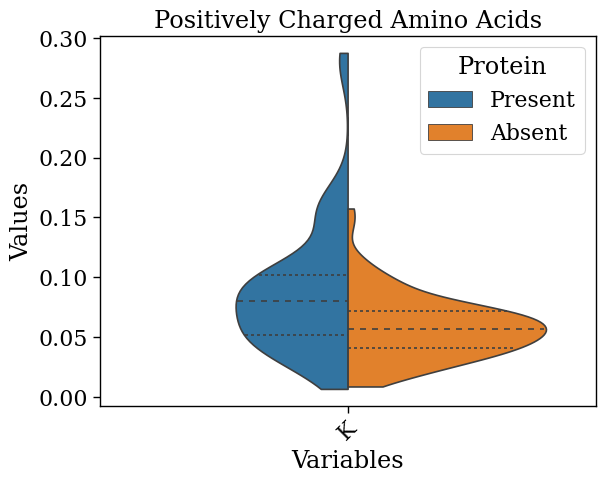

In [527]:
sns.violinplot(data=compPlot[compPlot['Variables'].isin(['K'])], x='Variables', hue='Protein', y='Values', split=True,inner = 'quart', cut = 0, pallete = 'colorblind')
plt.xticks(rotation=45)
plt.title('Positively Charged Amino Acids')
#plt.savefig('SecondaryStructure_PresvsAbsent.png',bbox_inches='tight')
#plt.clf()
plt.show()

Text(0.5, 1.0, 'Special Amino Acids')

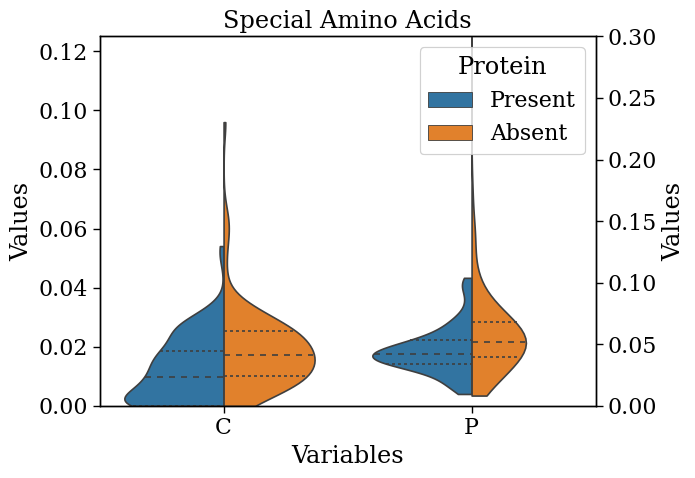

In [526]:
subPlot = compPlot[compPlot['Group']=='SingleAminoAcid']
subPlot = subPlot[subPlot['Variables'].isin(['C','P'])]
f, ax0 = plt.subplots()
ax1 = ax0.twinx()
var_order = ["C", "P"]
hue_order = ['Present', 'Absent']
i=0
for ax, var_name in zip([ax0, ax1], var_order):
    ax0.set_ylim(0,0.125)
    ax1.set_ylim(0,0.3)
    sns.violinplot(x=subPlot["Variables"], y=subPlot[subPlot['Variables'] == var_order[i]]['Values'], hue=subPlot["Protein"],ax=ax,split=True,inner = 'quart', cut = 0)
    i=i+1
plt.title('Special Amino Acids')
#plt.savefig('SingleAminoAcid_PresvsAbsent.png',bbox_inches='tight')

Text(0.5, 1.0, 'Plot in Paper')

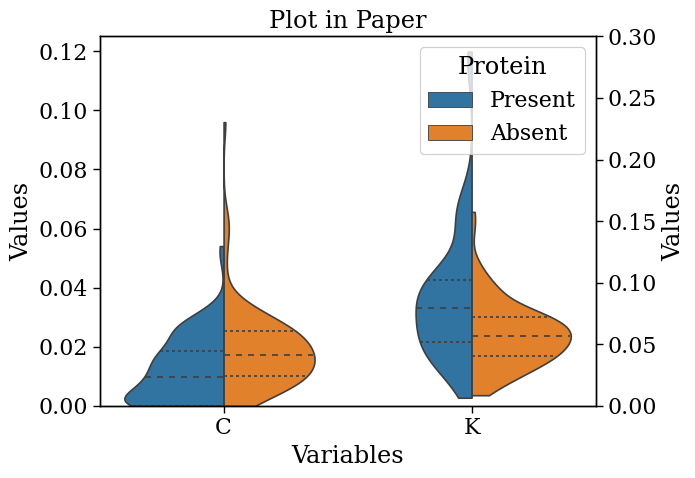

In [528]:
subPlot = compPlot[compPlot['Group']=='SingleAminoAcid']
subPlot = subPlot[subPlot['Variables'].isin(['C','K'])]
f, ax0 = plt.subplots()
ax1 = ax0.twinx()
var_order = ["C", "K"]
hue_order = ['Present', 'Absent']
i=0
for ax, var_name in zip([ax0, ax1], var_order):
    ax0.set_ylim(0,0.125)
    ax1.set_ylim(0,0.3)
    sns.violinplot(x=subPlot["Variables"], y=subPlot[subPlot['Variables'] == var_order[i]]['Values'], hue=subPlot["Protein"],ax=ax,split=True,inner = 'quart', cut = 0)
    i=i+1
plt.title('Plot in Paper')
#plt.savefig('SingleAminoAcid_PresvsAbsent.png',bbox_inches='tight')

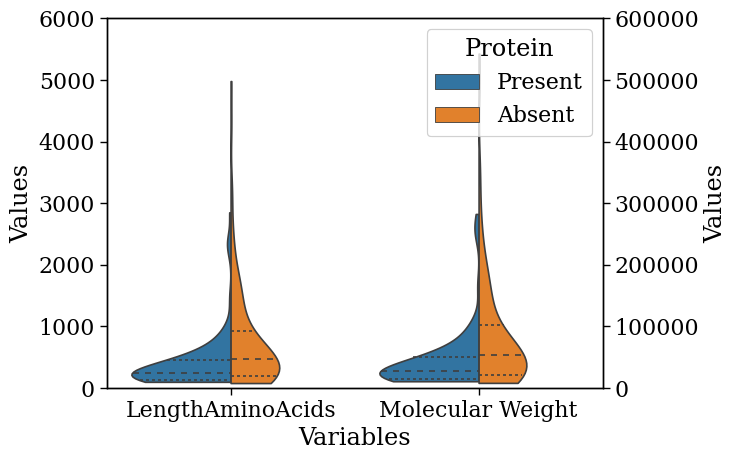

In [529]:
subPlot = compPlot[compPlot['Group']=='Size']
f, ax0 = plt.subplots()
ax1 = ax0.twinx()
var_order = ["LengthAminoAcids", "Molecular Weight"]
hue_order = ['Present', 'Absent']
i=0
for ax, var_name in zip([ax0, ax1], var_order):
    ax0.set_ylim(0,6000)
    ax1.set_ylim(0,600000)
    sns.violinplot(x=subPlot["Variables"], y=subPlot[subPlot['Variables'] == var_order[i]]['Values'], hue=subPlot["Protein"],ax=ax,split=True,inner = 'quart', cut = 0)
    i=i+1
#plt.savefig('Size_PresvsAbsent.png',bbox_inches='tight')

Text(0.5, 1.0, 'Plot in Paper')

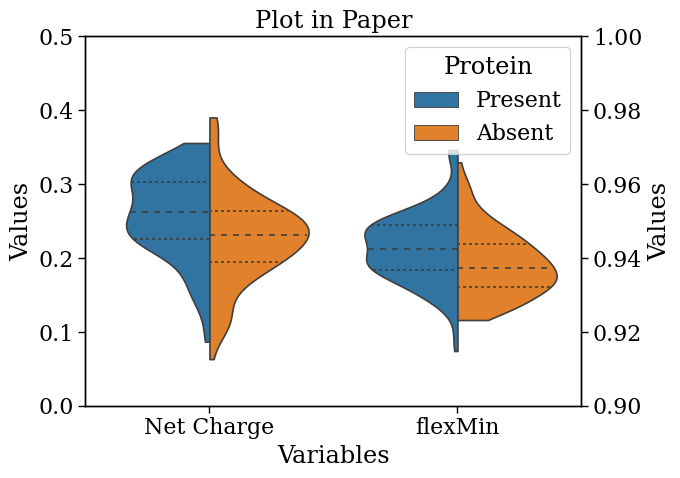

In [531]:
subPlot = compPlot[compPlot['Group']=='Bulk']
subPlot = subPlot[subPlot['Variables'].isin(['Net Charge','flexMin'])]
f, ax0 = plt.subplots()
ax1 = ax0.twinx()
var_order = ["Net Charge", "flexMin"]
hue_order = ['Present', 'Absent']
i=0
for ax, var_name in zip([ax0, ax1], var_order):
    ax0.set_ylim(0,0.5)
    ax1.set_ylim(.9,1)
    sns.violinplot(x=subPlot["Variables"], y=subPlot[subPlot['Variables'] == var_order[i]]['Values'], hue=subPlot["Protein"],ax=ax,split=True,inner = 'quart', cut = 0)
    i=i+1
plt.title('Plot in Paper')
#plt.savefig('SingleAminoAcid_PresvsAbsent.png',bbox_inches='tight')

Text(0.5, 1.0, 'Different Seconday Structure')

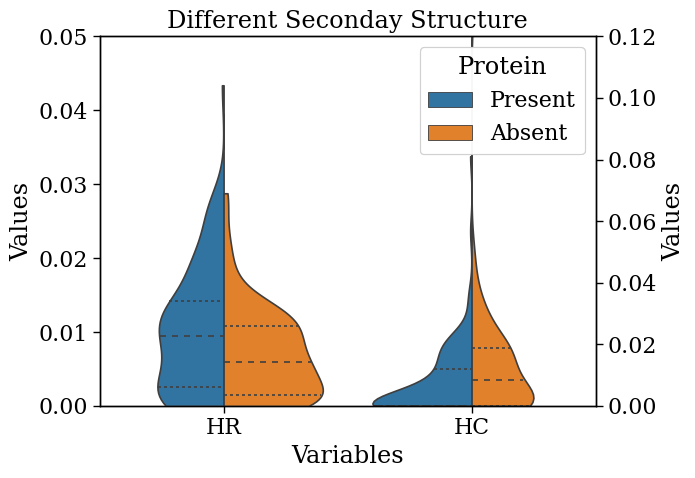

In [535]:
#subPlot = compPlot[compPlot['Group']=='SingleAminoAcid']
subPlot = compPlot[compPlot['Variables'].isin(['HC','HR'])]
f, ax0 = plt.subplots()
ax1 = ax0.twinx()
var_order = ["HC", "HR"]
hue_order = ['Present', 'Absent']
i=0
for ax, var_name in zip([ax0, ax1], var_order):
    ax0.set_ylim(0,0.05)
    ax1.set_ylim(0,0.12)
    sns.violinplot(x=subPlot["Variables"], y=subPlot[subPlot['Variables'] == var_order[i]]['Values'], hue=subPlot["Protein"],ax=ax,split=True,inner = 'quart', cut = 0)
    i=i+1
plt.title('Different Seconday Structure')

## Coated vs Uncoated

In [541]:
overallRes3

Protein  Abundance   Sample          ID
0                                 Clusterin           1    BoxPL      Q15846
1                          Apolipoprotein E           1    BoxPL      P02649
2                      Actin  cytoplasmic 2           1    BoxPL      P63261
3         Heat shock cognate 71 kDa protein           1    BoxPL      P11142
4                                   Annexin           1    BoxPL      O76027
...                                      ...        ...      ...         ...
8956     Immunoglobulin heavy variable 5-51           1  tube PL  A0A0C4DH38
8957  Immunoglobulin heavy constant gamma 2           0  tube PL      P01859
8958                        Complement C4-A           0  tube PL      P0C0L4
8959                        Serotransferrin           1  tube PL      P02787
8960                  Alpha-2-macroglobulin           0  tube PL      P01023

[8961 rows x 4 columns]

In [536]:
dataNew=dataPresent
abundance_binary=abundance_present

In [542]:
overallRes3=overallResPres

In [543]:
overallResPres.r

Present   Sample     Protein
0           1    BoxPL      Q15846
1           1    BoxPL      P02649
2           1    BoxPL      P63261
3           1    BoxPL      P11142
4           1    BoxPL      O76027
...       ...      ...         ...
9073        1  tube PL  A0A0C4DH38
9074        0  tube PL      P01859
9075        0  tube PL      P0C0L4
9076        1  tube PL      P02787
9077        0  tube PL      P01023

[9078 rows x 3 columns]

In [547]:
overallRes3.columns

Index(['Present', 'Sample', 'Protein'], dtype='object')

In [551]:
overallRes3=overallRes3.rename(columns={'Present':'Abundance','Protein':'ID'})

0.6275303643724697
0.4792332268370607
0.5535055350553506
0.7365853658536585
0.5361216730038023
0.716012084592145
0.6829268292682927


Text(0.5, 1.0, 'Coated vs Uncoated Structures')

<Figure size 800x600 with 0 Axes>

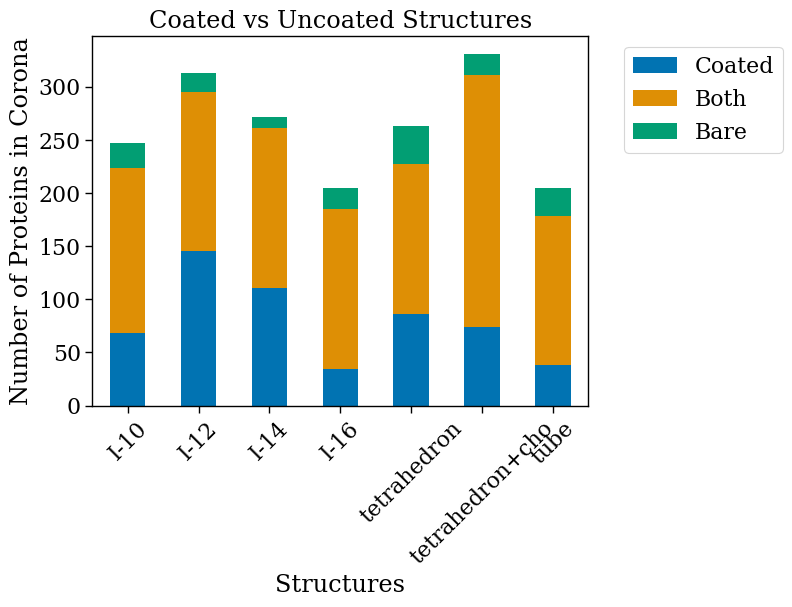

In [552]:
polCoated = dataNew[dataNew['PolyL'] == 1]
bare = dataNew[dataNew['PolyL'] == 0]
coatedAbundance = abundance_binary[dataNew['PolyL'] == 1]
bareAbundance =  abundance_binary[dataNew['PolyL'] == 0]

nonPlList = list()
plList = list()
bothList = list()
structures = list()
for c in np.unique(overallRes3['Sample']):
    if('PL' in c):
        if(c !='BoxPL'):
            both=0
            tetOnly = 0
            tetCholOnly=0

            tet = overallRes3[overallRes3['Sample'] == c]
            if(c == 'I-10PL'):
                tetChol = overallRes3[overallRes3['Sample'] == c[:-2]]
            else:
                tetChol = overallRes3[overallRes3['Sample'] == c[:-3]]
            for z in np.unique(overallRes3['ID']):
                if((tet['ID'].str.contains(z).any()) and (tetChol['ID'].str.contains(z).any())):
                    tetVal = tet[tet['ID'] == z]['Abundance'].values[0]
                    tetCholVal = tetChol[tetChol['ID'] == z]['Abundance'].values[0]
                    if(tetVal == 1 and tetCholVal == 1):
                        both = both +1
                    if(tetVal == 0 and tetCholVal == 1):
                        tetCholOnly=tetCholOnly+1
                    if(tetVal ==1 and tetCholVal == 0):
                        tetOnly = tetOnly+1
                    else:
                        continue
            nonPlList.append(tetCholOnly)
            if(c == 'I-10PL'):
                structures.append(c[:-2])
            else:
                structures.append(c[:-3])
            plList.append(tetOnly)
            bothList.append(both)
            print(both/(both+tetOnly+tetCholOnly))
            #venn2(subsets = (tetOnly, both, tetCholOnly), set_labels = (c, c[:-2]))
            plt.show()
            #plt.savefig(c+'PLvsNonPL.png'bbox_inches='tight')
            #plt.clf()
dfStack=pd.DataFrame({'Coated':plList,'Both':bothList,'Bare':nonPlList}, index = structures)

fig = plt.figure(figsize=(8, 6))
plt.rc('font', family='serif')
plt.rc('font', family='serif')

dfStack.plot(kind='bar', stacked=True, color = sns.color_palette("colorblind", 3),legend=False)
heights = list()
    
plt.xlabel('Structures')
plt.ylabel('Number of Proteins in Corona')
plt.xticks(rotation=45)
#plt.legend(bbox_to_anchor=(8, 1.0), loc='upper left')
#plt.tight_layout()
# title of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Coated vs Uncoated Structures')

## Cholesterol vs Non-cholesterol

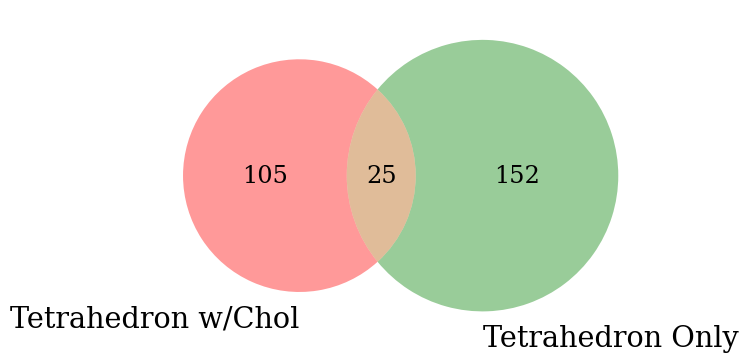

In [553]:
both=0
tetOnly = 0
tetCholOnly=0

tet = overallRes3[overallRes3['Sample'] == 'tetrahedron']
tetChol = overallRes3[overallRes3['Sample'] == 'tetrahedron+cho']
for z in np.unique(overallRes3['ID']):
    if(z not in tet['ID'].values):
        tetVal = 0
    else:
        tetVal = tet[tet['ID'] == z]['Abundance'].values[0]
    if(z not in tetChol['ID'].values):
        tetCholVal = 0
    else:
        tetCholVal = tetChol[tetChol['ID'] == z]['Abundance'].values[0]
    if(tetVal == 1 and tetCholVal == 1):
        both = both +1
    if(tetVal == 0 and tetCholVal == 1):
        tetCholOnly=tetCholOnly+1
    if(tetVal ==1 and tetCholVal == 0):
        tetOnly = tetOnly+1
    else:
        continue
venn2(subsets = (tetCholOnly,both,tetOnly), set_labels = ('Tetrahedron w/Chol','Tetrahedron Only'))
#plt.savefig('tetvstetChol.png',bbox_inches='tight')

In [598]:
pd.read_csv("C:\\Users\\jared\\Downloads\\string_interactions_short.tsv", sep = '\t')

#node1         node2       node1_string_id       node2_string_id  \
0      ABL1         DOCK1  9606.ENSP00000361423  9606.ENSP00000485033   
1      ABL1          ACTB  9606.ENSP00000361423  9606.ENSP00000494750   
2      ABL1  LOC102723407  9606.ENSP00000361423  9606.ENSP00000478289   
3      ACTB          MYH9  9606.ENSP00000494750  9606.ENSP00000216181   
4      ACTB           VTN  9606.ENSP00000494750  9606.ENSP00000226218   
..      ...           ...                   ...                   ...   
109   RAB5C          TFRC  9606.ENSP00000447053  9606.ENSP00000376197   
110   RAB7A          TFRC  9606.ENSP00000265062  9606.ENSP00000376197   
111  SNAP91          TFRC  9606.ENSP00000400459  9606.ENSP00000376197   
112    TFRC           VTN  9606.ENSP00000376197  9606.ENSP00000226218   
113   THBS1           VTN  9606.ENSP00000260356  9606.ENSP00000226218   

     neighborhood_on_chromosome  gene_fusion  phylogenetic_cooccurrence  \
0                             0          0.0                        0.0   
1                             0          0.0                        0.0   
2                             0          0.0                        0.0   
3                             0          0.0                        0.0   
4                             0          0.0                        0.0   
..                          ...          ...                        ...   
109                           0          0.0                        0.0   
110                           0          0.0                        0.0   
111                           0          0.0                        0.0   
112                           0          0.0                        0.0   
113                           0          0.0                        0.0   

     homology  coexpression  experimentally_determined_interaction  \
0         0.0         0.062                                  0.045   
1         0.0         0.079                                  0.070   
2         0.0         0.000                                  0.102   
3         0.0         0.420                                  0.680   
4         0.0         0.000                                  0.000   
..        ...           ...                                    ...   
109       0.0         0.074                                  0.167   
110       0.0         0.049                                  0.164   
111       0.0         0.000                                  0.000   
112       0.0         0.067                                  0.000   
113       0.0         0.042                                  0.000   

     database_annotated  automated_textmining  combined_score  
0                   0.0                 0.391           0.407  
1                   0.0                 0.521           0.554  
2                   0.0                 0.643           0.666  
3                   0.9                 0.602           0.991  
4                   0.0                 0.616           0.616  
..                  ...                   ...             ...  
109                 0.5                 0.221           0.659  
110                 0.4                 0.344           0.645  
111                 0.5                 0.347           0.659  
112                 0.0                 0.504           0.517  
113                 0.0                 0.825           0.826  

[114 rows x 13 columns]

## Endocytic Proteins

Text(0.5, 0, 'Protein Count')

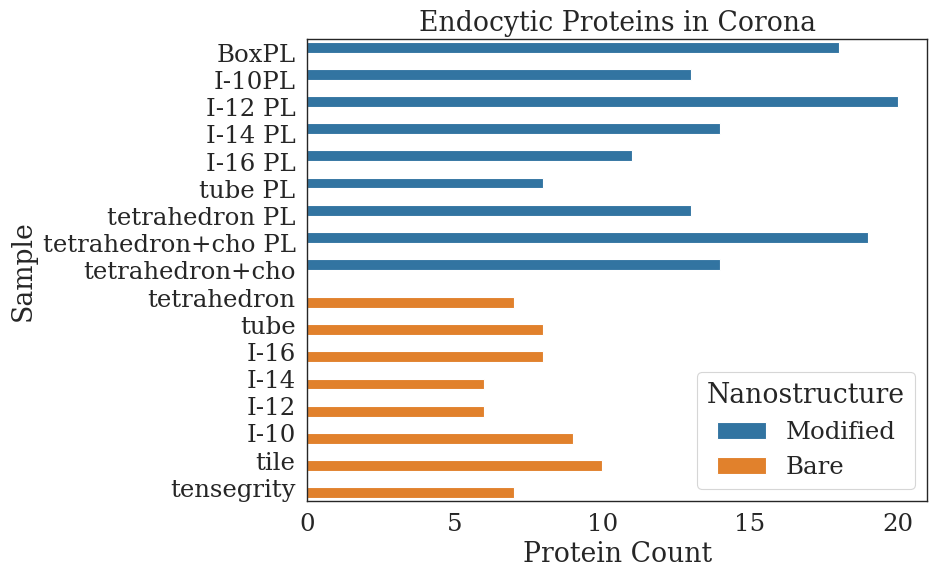

In [607]:
translate=pd.read_csv("C:\\Users\\jared\\Downloads\\string_mapping.tsv", sep = '\t')
endoPros=pd.read_csv("C:\\Users\\jared\\Downloads\\string_interactions_short.tsv", sep = '\t')

endoProteins=translate[translate['preferredName'].isin(list(set(list(endoPros['#node1']) + list(endoPros['node2']))))]
endoProteins.reset_index(drop=True, inplace = True)
endoProteins=endoProteins['queryItem']

samples = list()
endoCountList = list()
for x in np.unique(overallRes3['Sample']):
    samples.append(x)
    endoCount = 0
    for z in endoProteins:
        subRes=overallRes3[overallRes3['ID'] == z]
        subRes=subRes[subRes['Sample'] == x]
        if(subRes['Abundance'].values[0] == 1):
            endoCount = endoCount+1
    endoCountList.append(endoCount)
    
endo=pd.DataFrame({'Sample':samples, 'Count':endoCountList})
endocytosis=endo
endo.index = endo['Sample']

endocytosis=endocytosis.reindex(['BoxPL','I-10PL','I-12 PL','I-14 PL','I-16 PL','tube PL','tetrahedron PL','tetrahedron+cho PL','tetrahedron+cho','tetrahedron','tube','I-16','I-14','I-12','I-10','tile','tensegrity'])
endocytosis.transpose()

hueVec = list()
for z in endocytosis.index:
    if('PL' in z):
        hueVec.append('Modified')
        continue
    elif('cho' in z):
        hueVec.append('Modified')
        continue
    else:
        hueVec.append('Bare')
        
endo=endocytosis.melt(value_vars=['Count'])
endo.iloc[:,0] = endocytosis.index
endo=endo.rename({'variable':'Sample'},axis = 1)
endo=endo.rename({'value':'Protein Count'},axis = 1)
endo['Hue'] = hueVec
endo=endo.rename({'Hue':'Nanostructure'},axis = 1)

fig = plt.figure(figsize=(8, 6))
plt.rc('font', family='serif')
plt.rc('font', family='serif')

ax = sns.barplot(data=endo,y ='Sample',x = 'Protein Count', orient='h',hue = 'Nanostructure')
#plt.axvline(36,linewidth=4, color='r')
plt.title('Endocytic Proteins in Corona')
#plt.yaxis('Enrichment Value')
ax.set_xlabel('Protein Count')
#plt.savefig('EndocyticProteinEnrichment.png',bbox_inches='tight')

In [608]:
endo

Sample  Protein Count Nanostructure
0                BoxPL             18      Modified
1               I-10PL             13      Modified
2              I-12 PL             20      Modified
3              I-14 PL             14      Modified
4              I-16 PL             11      Modified
5              tube PL              8      Modified
6       tetrahedron PL             13      Modified
7   tetrahedron+cho PL             19      Modified
8      tetrahedron+cho             14      Modified
9          tetrahedron              7          Bare
10                tube              8          Bare
11                I-16              8          Bare
12                I-14              6          Bare
13                I-12              6          Bare
14                I-10              9          Bare
15                tile             10          Bare
16          tensegrity              7          Bare